# A simple economic model with an analytical solution

In this notebook, we use `TensorFlow 1.13.1` to showcase the general workflow of setting up and solving dynamic general equilibrium models with _deep equilibrium nets_. Use `pip install tensorflow==1.13.1` to install the correct version.

The notebook accompanies the working paper by [Azinovic, Gaegauf, & Scheidegger (2021)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3393482) and corresponds to the model solved in appendix F with a slighly different model calibration.

Note that this is a minimal working example for illustration purposes only. A more extensive implementation will be published on Github. 

The economic model we are solving in this example is one for which we know an exact solution. We chose to solve a model from [Krueger and Kubler (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903001118), which is based on [Huffman (1987)](https://www.journals.uchicago.edu/doi/10.1086/261445), because, in addition to being analytically solvable, it is closely related to the models solved in the paper. Therefore, the approach presented in this notebook translates directly to the models in working paper.

## The model <a id='model'></a>

We outline the model briefly. 

### tldr
The model has $A$ agents that only work in the first period of their lives. They optimize lifetime log utility by saving in risky capital. Agents consume everything in the last period. There is a representative firm that produces with labor and capital and is affected by TFP and depreciation shocks. The firm pays market prices for labor and capital.

***

### Households
Agents live for $A$ (here we consider $A = 6$) periods and have log utility. Agents only work in the first period of their life: $l^h_t=1$ for $h=0$ and $l^h_t=0$ otherwise. Therefore, the aggregate labor supply is constant and equal to one: $L_t=1$. Agents receive a competitive wage and can save in risky capital. Households cannot die with debt. Otherwise, there are no constraints or adjustment costs.
The household's problem is

$$ \max_{\{c_{t+i}^{i}, a_{t+i}^{i}\}_{i=0}^{A-1}}\mathbb{E}_{t}{\sum_{i=0}^{A-1}\log(c_{t+i}^{i})} $$
subject to:
$$c_{t}^{h} + a_t^{h} = r_t k_t^h + w_t l^h_t$$
$$k^{h+1}_{t+1} = a_t^h $$
$$a^{A-1}_t \geq 0$$

where $c_t^h$ denotes the consumption of age-group $h$ at time $t$, $a^h_t$ denotes the saving, $k_t^h$ denotes the available capital in the beginning of the period, $r_t$ denotes the price of capital, $l_t^h$ denotes the exogenously supplied labor endowment, and $w_t$ denotes the wage.

### Firms

There is a single representative firm with Cobb-Douglas production function.
The production function is given by
$$f(K_t,L_t,z_t) = \eta_t K^{\alpha}_t L^{1-\alpha}_t + K_t(1-\delta_t),$$
where $K_t$ denotes aggregate capital, where
$$K_t = \sum_{h=0}^{A-1} k^h_t,$$
$L_t$ denotes the aggregate labor supply, where
$$L_t = \sum_{h=0}^{A-1} l^h_t,$$
$\alpha$ denotes the capital share in production, $\eta_t$ denotes the stochastic TFP, and $\delta_t$ denotes the stochastic depreciation. The firm's optimization problem implies that the return on capital and the wage are given by
$$r_t = \alpha \eta_t K_t^{\alpha - 1} L_t^{1 - \alpha} + (1 - \delta_t),$$
$$w_t = (1 - \alpha) \eta_t K_t^{\alpha} L_t^{-\alpha}.$$

## Equilibrium

A competitive equilibrium, given initial conditions $z_0, \{ k_0^s \}_{s=0}^{A-1}$, is a collection of choices for households $ \{ (c_t^s, a_t^s)_{s = 0}^{A-1} \}_{t=0}^\infty$ and for the representative firm $(K_t, L_t)_{t=0}^\infty$ as well as prices $(r_t, w_t)_{t=0}^\infty$, such that

1. given prices, households optimize,
2. given prices, the firm maximizes profits,
3. markets clear.


## Table of contents

0. [Set up workspace](#workspace)
1. [Model calibration](#modelcal)
2. [_Deep equilibrium net_ hyper-parameters](#deqnparam)
    1. [Neural network](#nn)
3. [Economic model](#econmodel)
    1. [Current period (t)](#currentperiod)
    2. [Next period (t+1)](#nextperiod)
    3. [Cost/Euler function](#cost)
4. [Training](#training)

## 0. Set up workspace <a id='workspace'></a>

First, we need to set up the workspace. All of the packages are standard python packages. This version of the _deep equilibrium net_ notebook will be computed with `TensorFlow 1.13.1`. Make sure you are working in an environment with TF1 installed. Use `pip install tensorflow==1.13.1` to install the correct version.

The only special module is `utils` from which we import a mini-batch function `random_mini_batches` and a function that initializes the neural network weights `initialize_nn_weight`.

### Saving and continuing training

You can save and resume training by saving and loading the tensorflow session and data starting point.
* The saved session stores the neural network weights and the optimizer's state. If you have saved a session that you would like to reload, set `sess_path` to the session checkpoint path. For example, to load the 100th episode's session set `sess_path = './output/sess_100.ckpt'`. Otherwise, set `sess_path` to `None` to train from scratch. Currently, this script saves the session at the end of each [episode](#deqnparam).
* The saved data starting point stores the an exogeneous shock and a capital distribution, which can be used to simulate states into the future from. If you have saved a starting point that you would like to reload, set `data_path` to the numpy data path. For example, to load the 100th episode's starting point set `data_path = './output/data_100.npy'`. Otherwise, set `data_path` to `None` to train from scratch.

In [5]:
%matplotlib notebook

# Import modules
import os
import re
from datetime import datetime

import tensorflow as tf
import numpy as np
from utils import initialize_nn_weight, random_mini_batches

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
std_figsize = (4, 4)

# Make sure that we are working with tensorflow 1
print('tf version:', tf.__version__)
assert tf.__version__[0] == '1'

# Set the seed for replicable results
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

# Helper variables
eps = 0.00001  # Small epsilon value

# Make output directory to save network weights and starting point
if not os.path.exists('./output'):
    os.mkdir('./output')

# Path to saved tensorflow session
sess_path = None
# Path to saved data starting point
data_path = None

tf version: 1.13.1


## 1. Model calibration <a id='modelcal'></a>

### tldr

We solve a model with 6 agents. There are 4 exogenous shock which are the product of 2 depreciation ($\delta \in \{0.5, 0.9\}$) and 2 TFP shocks ($\eta \in \{0.95, 1.05\}$). Each shock-state has an equal probably of 0.25 of realizing in the next period. Agents only work in the first period. The economic parameters are calibrated to: $\alpha = 0.3$, $\beta=0.7$, and $\gamma = 1.0$.

***

We solve the model for $A = 6$ agents and base our parameterization on [Krueger and Kubler (2004)](https://www.sciencedirect.com/science/article/pii/S0165188903001118). 

### Shocks
The depreciation $\delta$ takes one of two values, $\delta \in \{0.5, 0.9\}$. The TFP $\eta$ also takes one of two values, $\eta \in \{0.95, 1.05\}$.
Both the TFP and depreciation shocks are i.i.d. with a transition matrix:
\begin{equation}
\Pi^{\eta} = \Pi^{\delta}=
\begin{bmatrix}
0.5 & 0.5 \\
0.5 & 0.5
\end{bmatrix}.
\end{equation}
and evolve independently of each other. In total, there are four possible combinations of depreciation shock and TFP shock that are labeled by $z \in \mathcal{Z}=\{1,2,3,4\}$ and correspond to $\delta=[0.5, 0.5, 0.9, 0.9]^T$ and $\eta=[0.95, 1.05, 0.95, 1.05]^T$. The overall transition matrix is given by
\begin{equation}
\Pi= \Pi^{\delta} \otimes \Pi^{\eta} = \begin{bmatrix}
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25
\end{bmatrix},
\end{equation} where $\Pi_{i, j}$ denotes the probability of a transition from the exogenous shock $i$ to exogenous shock $j$, where $i,j \in \mathcal{Z}$. 

### Labor
Agents in this economy are alive for 6 periods. Agents work in the first period of their lives before retiring for the remaining 4. That is, their labor endowment during their working age is 1 (and 0 otherwise).

### Production and household parameters
The output elasticity of the Cobb-Douglas production function is $\alpha = 0.3$, the discount factor of agents' utility is $\beta=0.7$, and the coeffient of risk aversion (in CRRA utility) is $\gamma = 1.0$.


In [8]:
# Number of agents and exogenous shocks
num_agents = A = 6
num_exogenous_shocks = 4

# Exogenous shock values
delta = tf.constant([[0.5], [0.5], [0.9], [0.9]],  dtype=tf.float32)  # Capital depreciation (dependent on shock)
eta = tf.constant([[0.95], [1.05], [0.95], [1.05]], dtype=tf.float32)  # TFP shock (dependent on shock)

# Transition matrix
# In this example we hardcoded the transition matrix. Changes cannot be made without also changing
# the corresponding code below.
p_transition = 0.25  # All transition probabilities are 0.25
pi_np = p_transition * np.ones((4, 4))  # Transition probabilities
pi = tf.constant(pi_np, dtype=tf.float32)  # Transition probabilities

# Labor endowment
labor_endow_np = np.zeros((1, A))
labor_endow_np[:, 0] = 1.0  # Agents only work in their first period
labor_endow = tf.constant(labor_endow_np, dtype=tf.float32)

# Production and household parameters
alpha = tf.constant(0.3)  # Capital share in production
beta_np = 0.7
beta = tf.constant(beta_np, dtype=tf.float32)  # Discount factor (patience)
gamma = tf.constant(1.0, dtype=tf.float32)  # CRRA coefficient

## 2. _Deep equilibrium net_ hyper-parameters <a id='deqnparam'></a>

Here, we will briefly outline the _deep equilibrium net_ architecture and choice of hyper-parameters. By hyper-parameters, we refer too all of the parameters that can be chosen freely by the modeller. This is in contrast to "parameters", which refers to the neural network weights that are learned during training.
We found it helpful to augment the state we pass to the neural network with redundant information, such as aggregate variables and the distribution of financial wealth.
In this notebook, we do the same.

  * Neural network architecture (see NN diagram below):
    * The neural network takes an extended state that is 32-dimensional:
        * Natural state:
            * 1 dimension for the shock index,
            * 6 dimensions for the distribution of capital across age groups
        * Redundant extension:
            * 1 dimension for the current TFP,
            * 1 dimension for the current depreciation,
            * 1 dimension for aggregate capital,
            * 1 dimension for aggregate labor supply, 
            * 1 dimension for the return on capital,
            * 1 dimension for the wage,
            * 1 dimension for the aggregate production,
            * 6 dimensions for the distribution of financial wealth,
            * 6 dimensions for the distribution of labor income, 
            * 6 dimensions for the distribution of total income.
    * The first and second hidden layers have 100 and 50 nodes, respectively.
    * The output layer is 5-dimensional.
  * Training hyper-parameters:
    * We simulate 5'000 episodes.*
    * Per episode, we compute 20 epochs.
    * We use a minibatch size of 512.
    * Each episode is 10'240 periods long.
    * The learning rate is set to 0.00001.

\* In the _deep equilibrium net_ framework we iterate between a simulation and training phase (see [training](#training)). We first simulate a training dataset based on the current state of the neural network. That is, we simulate a random sequence of exogenous shocks for which we compute the capital holdings of the agents. We call the set of simulated periods an _episode_. 5'000 episodes means that we re-simulate the training data 5'000 times.

Note that this calibration is not optimal for the economic model being solved. This script is intended to provide a simple introduction to _deep equilibrium nets_ and not an indepth discussion on optimizing the performance.

<img src='analytic_NN1.png' style="width:1000px">

In [9]:
num_episodes = 5000 
len_episodes = 10240
epochs_per_episode = 20
minibatch_size = 512
num_minibatches = int(len_episodes / minibatch_size)
lr = 0.00001

# Neural network architecture parameters
num_input_nodes = 8 + 4 * A  # Dimension of extended state space (8 aggregate quantities and 4 distributions)
num_hidden_nodes = [100, 50]  # Dimension of hidden layers
num_output_nodes = (A - 1)  # Output dimension (capital holding for each agent. Agent 1 is born without capital (k^1=0))

### 2.A. Neural network <a id='nn'></a>

Since we are using a neural network with 2 hidden layers, the network maps:
$$X \rightarrow \mathcal{N}(X) = \sigma(\sigma(XW_1 + b_1)W_2 + b_2)W_3 + b_3$$
where $\sigma$ is the rectified linear unit (ReLU) activation function and the output layer is activated with the linear function (which is the identity function and hence omitted from the equation). Therefore, we need 3 weight matrices $\{W_1, W_2, W_3\}$ and 3 bias vectors $\{b_1, b_2, b_3\}$ (compare with the neural network diagram above). In total, we train 5'954 parameters:

| $W_1$ | $32 \times 100$  | $= 3200$ |
| --- | --- | --- |
| $W_2$ | $100 \times 50$ | $= 5000$ |
| $W_3$ | $50 \times 5$ | $= 250$ |
| $b_1 + b_2 + b_3$ | $100 + 50 + 5$ | $= 155$|


We initialize the neural network parameters with the  `initialize_nn_weight` helper function from `utils`.

Then, we compute the neural network prediction using the parameters in `nn_predict`. 

In [14]:
# We create a placeholder for X, the input data for the neural network, which corresponds
# to the state.
X = tf.placeholder(tf.float32, shape=(None, num_input_nodes))
# Get number samples
m = tf.shape(X)[0]

# We create all of the neural network weights and biases. The weights are matrices that
# connect the layers of the neural network. For example, W1 connects the input layer to
# the first hidden layer
W1 = initialize_nn_weight([num_input_nodes, num_hidden_nodes[0]])
W2 = initialize_nn_weight([num_hidden_nodes[0], num_hidden_nodes[1]])
W3 = initialize_nn_weight([num_hidden_nodes[1], num_output_nodes])

# The biases are extra (shift) terms that are added to each node in the neural network.
b1 = initialize_nn_weight([num_hidden_nodes[0]])
b2 = initialize_nn_weight([num_hidden_nodes[1]])
b3 = initialize_nn_weight([num_output_nodes])

# Then, we create a function, to which we pass X, that generates a prediction based on
# the current neural network weights. Note that the hidden layers are ReLU activated.
# The output layer is not activated (i.e., it is activated with the linear function).
def nn_predict(X):
    hidden_layer1 = tf.nn.relu(tf.add(tf.matmul(X, W1), b1))
    hidden_layer2 = tf.nn.relu(tf.add(tf.matmul(hidden_layer1, W2), b2))
    output_layer = tf.add(tf.matmul(hidden_layer2, W3), b3)
    return output_layer


## 3. Economic model <a id='econmodel'></a>

In this section, we implement the economics outlined in [the model](#model).

Each period, based on the current distribution of capital and the exogenous state, agents decide whether and how much to save in risky capital and to consume. Their savings together with the labor supplied implies the rest of the economic state (e.g., capital return, wages, incomes, ...). We use the neural network to generate the savings based on the agents' capital holdings at the beginning of the period. The remaining economic state is computed using the equations outlined [above](#model). The economic mechanisms are encoded in helper functions. We create one for the `firm`, the `shocks`, and `wealth` (see cell below).

Then, in the face of future uncertainty, the agents again decide whether and how much to save in risky capital for the next period. We use the neural network to generate new savings for each of the future states (one for each shock). The input state for these network predictions is the next period's capital holding which are current periods savings.

First, we define the helper functions for the `firm`, the `shocks`, and `wealth`.


In [5]:
def firm(K, eta, alpha, delta):
    """Calculate return, wage and aggregate production.
    
    r = eta * K^(alpha-1) * L^(1-alpha) + (1-delta)
    w = eta * K^(alpha) * L^(-alpha)
    Y = eta * K^(alpha) * L^(1-alpha) + (1-delta) * K 

    Args:
        K: aggregate capital,
        eta: TFP value,
        alpha: output elasticity,
        delta: depreciation value.

    Returns:
        return: return (marginal product of capital), 
        wage: wage (marginal product of labor).
        Y: aggregate production.
    """
    L = tf.ones_like(K)

    r = alpha * eta * K**(alpha - 1) * L**(1 - alpha) + (1 - delta)
    w = (1 - alpha) * eta * K**alpha * L**(-alpha)
    Y = eta * K**alpha * L**(1 - alpha) + (1 - delta) * K

    return r, w, Y

def shocks(z, eta, delta):
    """Calculates tfp and depreciation based on current exogenous shock.

    Args:
        z: current exogenous shock (in {1, 2, 3, 4}),
        eta: tensor of TFP values to sample from,
        delta: tensor of depreciation values to sample from.

    Returns:
        tfp: TFP value of exogenous shock, 
        depreciation: depreciation values of exogenous shock.
    """
    tfp = tf.gather(eta, tf.cast(z, tf.int32))
    depreciation = tf.gather(delta, tf.cast(z, tf.int32))
    return tfp, depreciation
    
def wealth(k, R, l, W):
    """Calculates the wealth of the agents.

    Args:
        k: capital distribution,
        R: matrix of return,
        l: labor distribution,
        W: matrix of wages.

    Returns:
        fin_wealth: financial wealth distribution,
        lab_wealth: labor income distribution,
        tot_income: total income distribution.
    """
    fin_wealth = k * R
    lab_wealth = l * W
    tot_income = tf.add(fin_wealth, lab_wealth)
    return fin_wealth, lab_wealth, tot_income


### 3.A. Current period (t) <a id='currentperiod'></a>
Using the current state `X` we can calculate the economy. The state is composed of today's shock ($z_t$) and today's capital ($k_t^h$). Note that this constitutes the minimal state. Often, including redundant variables is a simple way to increase the speed of convergence (see the [working paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3393482) for more information on this). However, this notebook attempts to present the most basic example for simplicity.

Using the current state `X`, we predict how much the agents save ($a_t^h$) based on their current capital holdings ($k_t^h$). We do this by passing the state `X` to the neural network.

Then we can calculate the agents' consumptions. To do this, we need to calculate the aggregate capital ($K_t$), the return on capital payed by the firm ($r_t$), and the wages payed by the firm ($w_t$). 
$$K_t = \sum_{h=0}^{A-1} k_t^h,$$
$$r_t = \alpha \eta_t K_t^{\alpha - 1} L_t^{1 - \alpha} + (1 - \delta_t),$$
$$w_t = (1 - \alpha) \eta_t K_t^{\alpha} L_t^{-\alpha}.$$

Aggregate labor $L_t$ is always 1 by construction. Then, we can calculate each agent's total income. Finally, we calculate the resulting consumption ($c_t^h$):
$$c_{t}^{h} = r_t k_t^h + w_t l^h_t - a_t^{h}.$$

In [6]:
# Today's extended state: 
z = X[:, 0]  # exogenous shock
tfp = X[:, 1]  # total factor productivity
depr = X[:, 2]  # depreciation
K = X[:, 3]  # aggregate capital
L = X[:, 4]  # aggregate labor
r = X[:, 5]  # return on capital
w = X[:, 6]  # wage
Y = X[:, 7]  # aggregate production
k = X[:, 8 : 8 + A]  # distribution of capital
fw = X[:, 8 + A : 8 + 2 * A]  # distribution of financial wealth
linc = X[:, 8 + 2 * A : 8 + 3 * A]  # distribution of labor income
inc = X[:, 8 + 3 * A : 8 + 4 * A]   # distribution of total income

# Today's assets: How much the agents save
# Get today's assets by executing the neural network
a = nn_predict(X)
# The last agent consumes everything they own
a_all = tf.concat([a, tf.zeros([m, 1])], axis=1)

# c_orig: the original consumption predicted by the neural network However, the
#     network can predict negative values before it learns not to. We ensure that
#     the network learns itself out of a bad region by penalizing negative
#     consumption. We ensure that consumption is not negative by including a penalty
#     term on c_orig_prime_1
# c: is the corrected version c_all_orig_prime_1, in which all negative consumption
#     values are set to ~0. If none of the consumption values are negative then
#     c_orig_prime_1 == c_prime_1.
c_orig = inc - a_all
c = tf.maximum(c_orig, tf.ones_like(c_orig) * eps)

### 3.B. Next period (t+1) <a id='nextperiod'></a>

Now that we have calculated the current economic variables, we simulate one period forward. Since we have 4 possible futures---1 for each of the possible shocks that can realize---we simulate forward for each of the 4 states. Hence, we repeat each calculation 4 times. Below, we first calculate the aggregate variables for the beginning of the period. Then, we calculate the economy for shock $z=1$. The calculations for shock 2, 3, and 4 are analogous and will not be commented on.

From the current period's savings $a_t$ we can calculate the next period's capital holdings $k_{t+1}^h$ and, consequently, aggregate capital $K_{t+1}$. Again, aggregate labor $L_{t+1}$ is 1 by construction.

Then, like above, we calculate economic variables for each shock $z_{t+1} \in \{1, 2, 3, 4\}$. That is, the new state `X'`$=[z_{t+1}, k_{t+1}^h]$ (together with the redundant extensions) is passed to the neural network to generate the agents' savings $a_{t+1}^h$. Then, we use `firm`, the `shocks`, and `wealth` to calculate the return on capital ($r_{t+1}$), the wages ($w_{t+1}$), and the agents' total income. Finally, consumption $c_{t+1}^h$ is calculated.

In [7]:
# Today's savings become tomorrow's capital holding, but the first agent
# is born without a capital endowment.
k_prime = tf.concat([tf.zeros([m, 1]), a], axis=1)

# Tomorrow's aggregate capital
K_prime_orig = tf.reduce_sum(k_prime, axis=1, keepdims=True)
K_prime = tf.maximum(K_prime_orig, tf.ones_like(K_prime_orig) * eps)

# Tomorrow's labor
l_prime = tf.tile(labor_endow, [m, 1])
L_prime = tf.ones_like(K_prime)

# Shock 1 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_1 = 0 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_1, depr_prime_1 = shocks(z_prime_1, eta, delta)

# Return on capital, wage and aggregate production
r_prime_1, w_prime_1, Y_prime_1 = firm(K_prime, tfp_prime_1, alpha, depr_prime_1)
R_prime_1 = r_prime_1 * tf.ones([1, A])
W_prime_1 = w_prime_1 * tf.ones([1, A])

# Distribution of financial wealth, labor income, and total income
fw_prime_1, linc_prime_1, inc_prime_1 = wealth(k_prime, R_prime_1, l_prime, W_prime_1)

# Tomorrow's state: Concatenate the parts together
x_prime_1 = tf.concat([tf.expand_dims(z_prime_1, -1),
                       tfp_prime_1,
                       depr_prime_1,
                       K_prime,
                       L_prime,
                       r_prime_1,
                       w_prime_1,
                       Y_prime_1,
                       k_prime,
                       fw_prime_1,
                       linc_prime_1,
                       inc_prime_1], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_1 = nn_predict(x_prime_1)
a_prime_all_1 = tf.concat([a_prime_1, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_1 = inc_prime_1 - a_prime_all_1
c_prime_1 = tf.maximum(c_orig_prime_1, tf.ones_like(c_orig_prime_1) * eps)

#### Repeat for the remaining shocks
Then, we do the same for the remaining shocks ($z = 2,3,4$). Nothing changes in terms of the math for the remaining shocks.

In [8]:
# Shock 2 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_2 = 1 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_2, depr_prime_2 = shocks(z_prime_2, eta, delta)

# return on capital, wage and aggregate production
r_prime_2, w_prime_2, Y_prime_2 = firm(K_prime, tfp_prime_2, alpha, depr_prime_2)
R_prime_2 = r_prime_2 * tf.ones([1, A])
W_prime_2 = w_prime_2 * tf.ones([1, A])

# distribution of financial wealth, labor income, and total income
fw_prime_2, linc_prime_2, inc_prime_2 = wealth(k_prime, R_prime_2, l_prime, W_prime_2)

# Tomorrow's state: Concatenate the parts together
x_prime_2 = tf.concat([tf.expand_dims(z_prime_2, -1),
                       tfp_prime_2,
                       depr_prime_2,
                       K_prime,
                       L_prime,
                       r_prime_2,
                       w_prime_2,
                       Y_prime_2,
                       k_prime,
                       fw_prime_2,
                       linc_prime_2,
                       inc_prime_2], axis=1)

# 2) Get tomorrow's policy
a_prime_2 = nn_predict(x_prime_2)
a_prime_all_2 = tf.concat([a_prime_2, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_2 = inc_prime_2 - a_prime_all_2
c_prime_2= tf.maximum(c_orig_prime_2, tf.ones_like(c_orig_prime_2) * eps)

# Shock 3 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_3 = 2 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_3, depr_prime_3 = shocks(z_prime_3, eta, delta)

# return on capital, wage and aggregate production
r_prime_3, w_prime_3, Y_prime_3 = firm(K_prime, tfp_prime_3, alpha, depr_prime_3)
R_prime_3 = r_prime_3 * tf.ones([1, A])
W_prime_3 = w_prime_3 * tf.ones([1, A])

# distribution of financial wealth, labor income, and total income
fw_prime_3, linc_prime_3, inc_prime_3 = wealth(k_prime, R_prime_3, l_prime, W_prime_3)

# Tomorrow's state: Concatenate the parts together
x_prime_3 = tf.concat([tf.expand_dims(z_prime_3, -1),
                       tfp_prime_3,
                       depr_prime_3,
                       K_prime,
                       L_prime,
                       r_prime_3,
                       w_prime_3,
                       Y_prime_3,
                       k_prime,
                       fw_prime_3,
                       linc_prime_3,
                       inc_prime_3], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_3 = nn_predict(x_prime_3)
a_prime_all_3 = tf.concat([a_prime_3, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_3 = inc_prime_3 - a_prime_all_3
c_prime_3 = tf.maximum(c_orig_prime_3, tf.ones_like(c_orig_prime_3) * eps)

# Shock 4 ---------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_4 = 3 * tf.ones_like(z)

# TFP and depreciation
tfp_prime_4, depr_prime_4 = shocks(z_prime_4, eta, delta)

# return on capital, wage and aggregate production
r_prime_4, w_prime_4, Y_prime_4 = firm(K_prime, tfp_prime_4, alpha, depr_prime_4)
R_prime_4 = r_prime_4 * tf.ones([1, A])
W_prime_4 = w_prime_4 * tf.ones([1, A])

# distribution of financial wealth, labor income, and total income
fw_prime_4, linc_prime_4, inc_prime_4 = wealth(k_prime, R_prime_4, l_prime, W_prime_4)

# Tomorrow's state: Concatenate the parts together
x_prime_4 = tf.concat([tf.expand_dims(z_prime_4, -1),
                       tfp_prime_4,
                       depr_prime_4,
                       K_prime,
                       L_prime,
                       r_prime_4,
                       w_prime_4,
                       Y_prime_4,
                       k_prime,
                       fw_prime_4,
                       linc_prime_4,
                       inc_prime_4], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_4 = nn_predict(x_prime_4)
a_prime_all_4 = tf.concat([a_prime_4, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption
c_orig_prime_4 = inc_prime_4 - a_prime_all_4
c_prime_4 = tf.maximum(c_orig_prime_4, tf.ones_like(c_orig_prime_4) * eps)


### 3.C. Cost / Euler function <a id='cost'></a>

#### tldr

We train the neural network in an unsupervised fashion by approximating the equilibrium functions. The cost function is composed of the Euler equation, and the punishments for negative consumption and negative aggregate capital.

***

The final key ingredient is the cost function, which encodes the equilibrium functions.

A loss function is needed to train a neural network. In supervised learning, the neural network's prediction is compared to the true value. The weights are updated in the direction that decreases the discripancy between the prediction and the truth. In _deep equilibrium nets_, we approximate all equilibrium functions directly. That is, we update the weights in the direction that minimizes these equilibrium functions. Since the equilibrium functions are approximately 0 in equilibrium, we do not require labeled data and can train in an unsupervised fashion.

Our loss function has 3 components:

  * the Euler equation,
  * the punishments for negative consumption, and
  * the punishments for negative aggregate capital.

The relative errors in the Euler equation is given by:
$$e_{\text{REE}}^i(\mathbf{x}_j) := \frac{u^{\prime -1}\left(\beta \mathbf{E}_{z_j}{r(\hat{\mathbf{x}}_{j,+})u^{\prime}(\hat{c}^{i+1}(\hat{\mathbf{x}}_{j,+}))}\right)}{\hat{c}^i(\mathbf{x}_j)}-1$$

In [9]:
# Prepare transitions to the next periods states. In this setting, there is a 25% chance
# of ending up in any of the 4 states in Z. This has been hardcoded and need to be changed
# to accomodate a different transition matrix.
pi_trans_to1 = p_transition * tf.ones((m, A-1))
pi_trans_to2 = p_transition * tf.ones((m, A-1))
pi_trans_to3 = p_transition * tf.ones((m, A-1))
pi_trans_to4 = p_transition * tf.ones((m, A-1))

# Euler equation
opt_euler = - 1 + (
    (
        (
            beta * (
                pi_trans_to1 * R_prime_1[:, 0:A-1] * c_prime_1[:, 1:A]**(-gamma) 
                + pi_trans_to2 * R_prime_2[:, 0:A-1] * c_prime_2[:, 1:A]**(-gamma) 
                + pi_trans_to3 * R_prime_3[:, 0:A-1] * c_prime_3[:, 1:A]**(-gamma) 
                + pi_trans_to4 * R_prime_4[:, 0:A-1] * c_prime_4[:, 1:A]**(-gamma)
            )
        ) ** (-1. / gamma)
    ) / c[:, 0:A-1]
)

# Punishment for negative consumption (c)
orig_cons = tf.concat([c_orig, c_orig_prime_1, c_orig_prime_2, c_orig_prime_3, c_orig_prime_4], axis=1)
opt_punish_cons = (1./eps) * tf.maximum(-1 * orig_cons, tf.zeros_like(orig_cons))

# Punishment for negative aggregate capital (K)
opt_punish_ktot_prime = (1./eps) * tf.maximum(-K_prime_orig, tf.zeros_like(K_prime_orig))

# Concatenate the 3 equilibrium functions
combined_opt = [opt_euler, opt_punish_cons, opt_punish_ktot_prime]
opt_predict = tf.concat(combined_opt, axis=1)

# Define the "correct" outputs. For all equilibrium functions, the correct outputs is zero.
opt_correct = tf.zeros_like(opt_predict)


#### Optimizer

Next, we chose an optimizer; i.e., the algorithm we use to perform gradient descent. We use [Adam](https://arxiv.org/abs/1412.6980), a favorite in deep learning research. Adam uses a parameter specific learning rate and momentum, which encourages gradient descent steps that occur in a consistent direction.

In [10]:
# Define the cost function
cost = tf.losses.mean_squared_error(opt_correct, opt_predict)

# Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# Clip the gradients to limit the extent of exploding gradients
gvs = optimizer.compute_gradients(cost)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]

# Define a training step
train_step = optimizer.apply_gradients(capped_gvs)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## 4. Training <a id='training'></a>

### tldr

We iterate between simulating a dataset using the current neural network and training on this dataset.

***

In the final stage, we put everything together and train the neural network. 

In this section, we iterate between a simulation phase and a training phase. That is, we first simulate a dataset. We simulate a sequence of states ($[z, k]$) based on a random sequence of shocks. The states are computed using the current state of the neural network. We created the `simulate_episodes` helper function to do this. Then, in the training phase, we use the dataset to update our network parameters through multiple epochs. After completion of the training phase, we resimulate a dataset using the new network parameters and repeat.

By computing the error directly after simulating a new dataset, we are able to evaluate our algorithms out-of-sample performance.

First, we define the helper function `simulate_episodes` that simulates the training data used in an episode.

In [11]:
def simulate_episodes(sess, x_start, episode_length, print_flag=True):
    """Simulate an episode for a given starting point using the current
       neural network state.

    Args:
        sess: Current tensorflow session,
        x_start: Starting state to simulate forward from,
        episode_length: Number of steps to simulate forward,
        print_flag: Boolean that determines whether to print simulation stats.

    Returns:
        X_episodes: Tensor of states [z, k] to train on (training set).
    """
    time_start = datetime.now()
    if print_flag:
        print('Start simulating {} periods.'.format(episode_length))
    dim_state = np.shape(x_start)[1]

    X_episodes = np.zeros([episode_length, dim_state])
    X_episodes[0, :] = x_start
    X_old = x_start

    # Generate a sequence of random shocks
    rand_num = np.random.rand(episode_length, 1)

    for t in range(1, episode_length):
        z = int(X_old[0, 0])  # Current period's shock

        # Determine which state we will be in in the next period based on
        # the shock and generate the corresponding state (x_prime)
        if rand_num[t - 1] <= pi_np[z, 0]:
            X_new = sess.run(x_prime_1, feed_dict={X: X_old})
        elif rand_num[t - 1] <= pi_np[z, 0] + pi_np[z, 1]:
            X_new = sess.run(x_prime_2, feed_dict={X: X_old})
        elif rand_num[t - 1] <= pi_np[z, 0] + pi_np[z, 1] + pi_np[z, 2]:
            X_new = sess.run(x_prime_3, feed_dict={X: X_old})
        else:
            X_new = sess.run(x_prime_4, feed_dict={X: X_old})
        
        # Append it to the dataset
        X_episodes[t, :] = X_new
        X_old = X_new

    time_end = datetime.now()
    time_diff = time_end - time_start
    if print_flag:
        print('Finished simulation. Time for simulation: {}.'.format(time_diff))

    return X_episodes

### The true analytic solution
This model can be solved analytically.
Therefore, additionally to the relative errors in the Euler equations, we can compare the solution learned by the neural network directly to the true solution.
The true policy is given by
\begin{align}
\mathbf{a}^{\text{analytic}}_t=
\beta
\begin{bmatrix}
\frac{1-\beta^{A-1}}{1-\beta^{A}} w_t \\
\frac{1-\beta^{A-2}}{1-\beta^{A-1}} r_t k^{1}_t \\
\frac{1-\beta^{A-3}}{1-\beta^{A-2}} r_t k^{2}_t \\
\dots \\
\frac{1-\beta^{1}}{1-\beta^2} r_t k^{A-2}_t \\
\end{bmatrix}.
\end{align}

In [12]:
beta_vec = beta_np * (1 - beta_np ** (A - 1 - np.arange(A-1))) / (1 - beta_np ** (A - np.arange(A-1)))
beta_vec = tf.constant(np.expand_dims(beta_vec, 0), dtype=tf.float32)
a_analytic = inc[:, : -1] * beta_vec

### Training the _deep equilibrium net_

Now we can begin training.

<IPython.core.display.Javascript object>


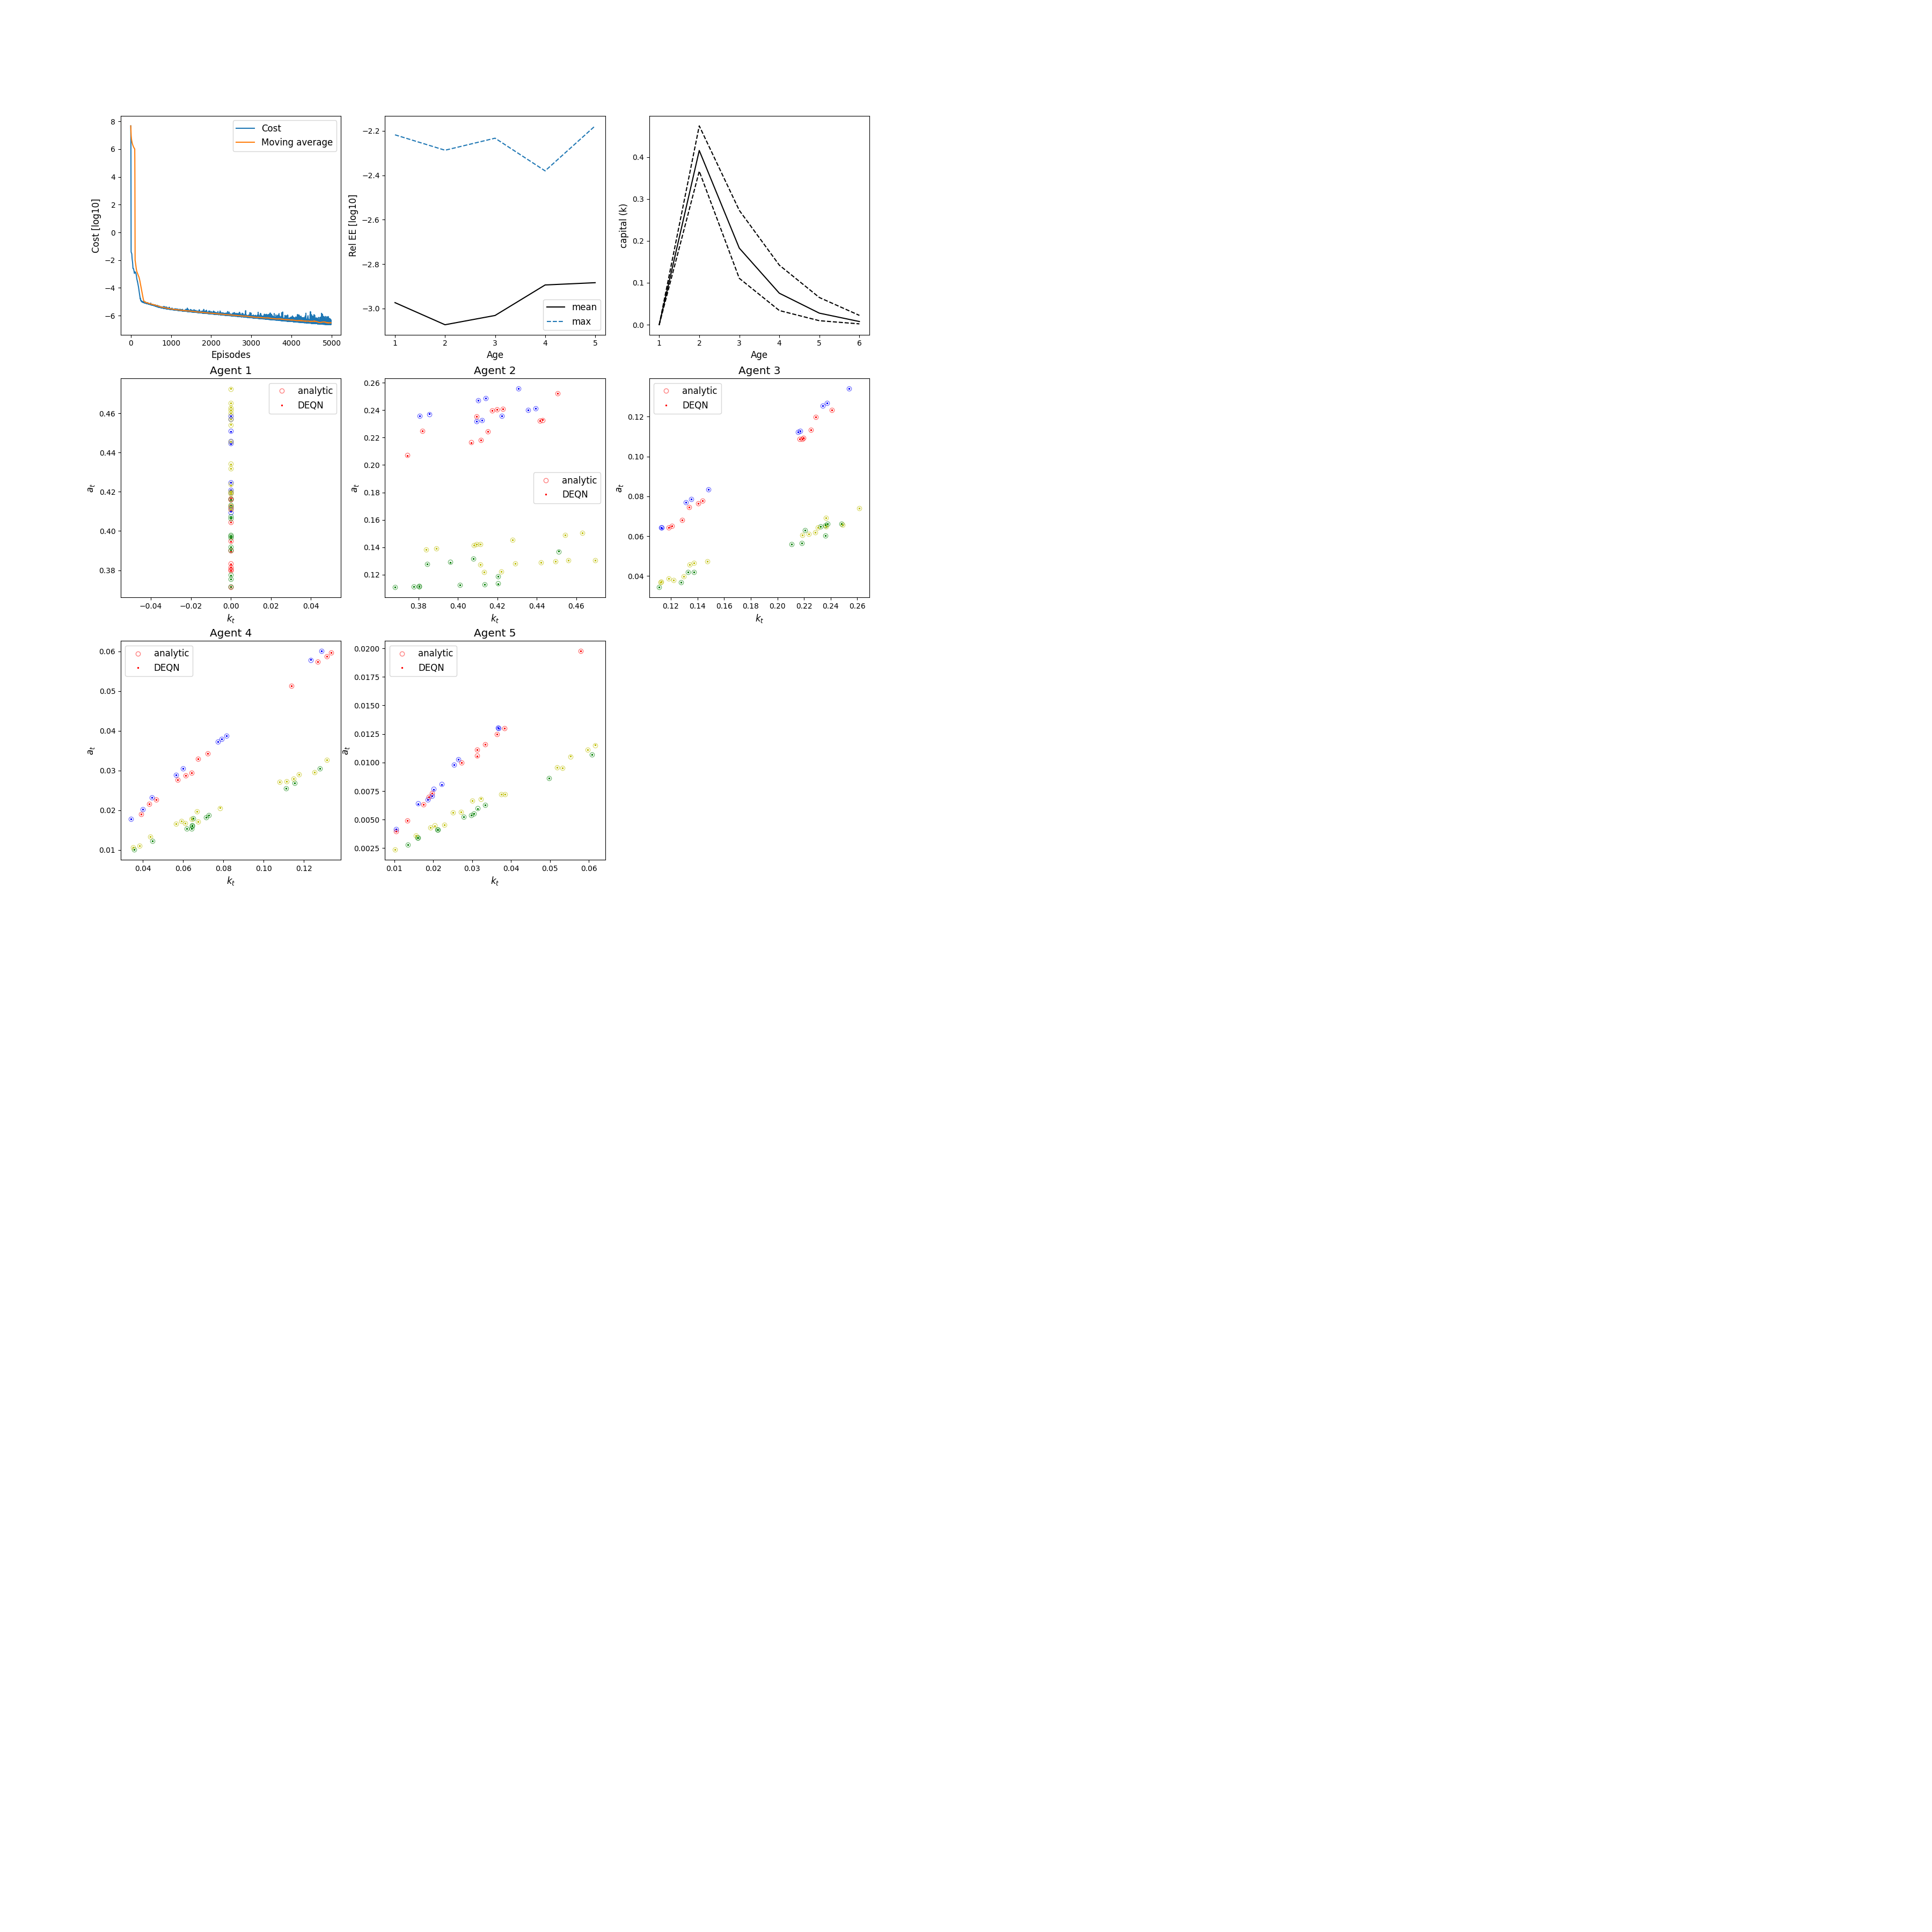

Calculated a valid starting point
start time: 2020-03-31 17:18:56.903886
Start simulating 10240 periods.
Finished simulation. Time for simulation: 0:00:03.566488.
Episode 0: log10(Cost): 7.6816; time: 17:19:06.029277; time since start: 0:00:09.125394
Episode 1: log10(Cost): 7.5046; time: 17:19:13.013161; time since start: 0:00:16.109279
Episode 2: log10(Cost): 7.2268; time: 17:19:19.860568; time since start: 0:00:22.956685
Episode 3: log10(Cost): 6.6636; time: 17:19:26.607294; time since start: 0:00:29.703413
Episode 4: log10(Cost): 5.8305; time: 17:19:33.416850; time since start: 0:00:36.512968
Episode 5: log10(Cost): 4.1768; time: 17:19:40.250339; time since start: 0:00:43.346458
Episode 6: log10(Cost): 2.4361; time: 17:19:47.000216; time since start: 0:00:50.096334
Episode 7: log10(Cost): -1.1820; time: 17:19:53.880211; time since start: 0:00:56.976329
Episode 8: log10(Cost): -1.3201; time: 17:20:00.784004; time since start: 0:01:03.880122
Episode 9: log10(Cost): -1.3873; time: 17:2

Episode 90: log10(Cost): -2.9487; time: 17:29:24.390759; time since start: 0:10:27.486877
Episode 91: log10(Cost): -2.9566; time: 17:29:31.208777; time since start: 0:10:34.304896
Episode 92: log10(Cost): -2.9565; time: 17:29:38.114966; time since start: 0:10:41.211084
Episode 93: log10(Cost): -2.9545; time: 17:29:44.900685; time since start: 0:10:47.996803
Episode 94: log10(Cost): -2.9494; time: 17:29:51.712129; time since start: 0:10:54.808246
Episode 95: log10(Cost): -2.9431; time: 17:29:58.535355; time since start: 0:11:01.631473
Episode 96: log10(Cost): -2.9366; time: 17:30:05.334127; time since start: 0:11:08.430245
Episode 97: log10(Cost): -2.9303; time: 17:30:12.161518; time since start: 0:11:15.257636
Episode 98: log10(Cost): -2.9164; time: 17:30:18.993364; time since start: 0:11:22.089481
Episode 99: log10(Cost): -2.9125; time: 17:30:25.822564; time since start: 0:11:28.918682
Episode 100: log10(Cost): -2.9034; time: 17:30:33.263076; time since start: 0:11:36.359193
Episode 1

Episode 181: log10(Cost): -3.7479; time: 17:39:49.241352; time since start: 0:20:52.337471
Episode 182: log10(Cost): -3.7653; time: 17:39:56.094626; time since start: 0:20:59.190743
Episode 183: log10(Cost): -3.7741; time: 17:40:02.961320; time since start: 0:21:06.057438
Episode 184: log10(Cost): -3.7895; time: 17:40:09.848309; time since start: 0:21:12.944427
Episode 185: log10(Cost): -3.8081; time: 17:40:16.685703; time since start: 0:21:19.781821
Episode 186: log10(Cost): -3.8257; time: 17:40:23.567970; time since start: 0:21:26.664089
Episode 187: log10(Cost): -3.8417; time: 17:40:30.367124; time since start: 0:21:33.463242
Episode 188: log10(Cost): -3.8585; time: 17:40:37.188425; time since start: 0:21:40.284544
Episode 189: log10(Cost): -3.8758; time: 17:40:44.087412; time since start: 0:21:47.183531
Episode 190: log10(Cost): -3.8918; time: 17:40:50.922971; time since start: 0:21:54.019090
Episode 191: log10(Cost): -3.9096; time: 17:40:57.692272; time since start: 0:22:00.788394

Episode 272: log10(Cost): -4.9878; time: 17:50:20.695007; time since start: 0:31:23.791125
Episode 273: log10(Cost): -4.9675; time: 17:50:27.552100; time since start: 0:31:30.648219
Episode 274: log10(Cost): -4.9910; time: 17:50:34.419091; time since start: 0:31:37.515209
Episode 275: log10(Cost): -4.9980; time: 17:50:41.274242; time since start: 0:31:44.370360
Episode 276: log10(Cost): -5.0002; time: 17:50:48.108539; time since start: 0:31:51.204658
Episode 277: log10(Cost): -5.0034; time: 17:50:54.986434; time since start: 0:31:58.082552
Episode 278: log10(Cost): -4.9997; time: 17:51:01.847085; time since start: 0:32:04.943203
Episode 279: log10(Cost): -4.9985; time: 17:51:08.693037; time since start: 0:32:11.789156
Episode 280: log10(Cost): -5.0066; time: 17:51:16.248781; time since start: 0:32:19.344898
Episode 281: log10(Cost): -5.0081; time: 17:51:23.156920; time since start: 0:32:26.253039
Episode 282: log10(Cost): -4.9971; time: 17:51:30.030598; time since start: 0:32:33.126717

Episode 363: log10(Cost): -5.1022; time: 18:00:49.290032; time since start: 0:41:52.386150
Episode 364: log10(Cost): -5.0911; time: 18:00:56.065671; time since start: 0:41:59.161789
Episode 365: log10(Cost): -5.0811; time: 18:01:02.877438; time since start: 0:42:05.973557
Episode 366: log10(Cost): -5.0400; time: 18:01:09.775587; time since start: 0:42:12.871705
Episode 367: log10(Cost): -5.0103; time: 18:01:16.738051; time since start: 0:42:19.834169
Episode 368: log10(Cost): -5.1050; time: 18:01:23.562463; time since start: 0:42:26.658581
Episode 369: log10(Cost): -5.0829; time: 18:01:30.361862; time since start: 0:42:33.457979
Episode 370: log10(Cost): -5.0901; time: 18:01:37.311266; time since start: 0:42:40.407383
Episode 371: log10(Cost): -5.1104; time: 18:01:44.180495; time since start: 0:42:47.276613
Episode 372: log10(Cost): -5.0620; time: 18:01:51.036180; time since start: 0:42:54.132297
Episode 373: log10(Cost): -5.1083; time: 18:01:57.841195; time since start: 0:43:00.937313

Episode 454: log10(Cost): -5.1772; time: 18:11:16.114251; time since start: 0:52:19.210369
Episode 455: log10(Cost): -5.1665; time: 18:11:22.864872; time since start: 0:52:25.960990
Episode 456: log10(Cost): -5.1679; time: 18:11:29.634842; time since start: 0:52:32.730963
Episode 457: log10(Cost): -5.1708; time: 18:11:36.496641; time since start: 0:52:39.592760
Episode 458: log10(Cost): -5.1789; time: 18:11:43.287795; time since start: 0:52:46.383913
Episode 459: log10(Cost): -5.1830; time: 18:11:50.121207; time since start: 0:52:53.217325
Episode 460: log10(Cost): -5.1759; time: 18:11:57.767174; time since start: 0:53:00.863291
Episode 461: log10(Cost): -5.1778; time: 18:12:04.596357; time since start: 0:53:07.692474
Episode 462: log10(Cost): -5.1805; time: 18:12:11.401971; time since start: 0:53:14.498090
Episode 463: log10(Cost): -5.1852; time: 18:12:18.212191; time since start: 0:53:21.308311
Episode 464: log10(Cost): -5.1804; time: 18:12:25.033721; time since start: 0:53:28.129840

Episode 541: log10(Cost): -5.2317; time: 18:21:15.189835; time since start: 1:02:18.285953
Episode 542: log10(Cost): -5.2511; time: 18:21:22.007562; time since start: 1:02:25.103680
Episode 543: log10(Cost): -5.2536; time: 18:21:28.764231; time since start: 1:02:31.860349
Episode 544: log10(Cost): -5.2103; time: 18:21:35.595300; time since start: 1:02:38.691419
Episode 545: log10(Cost): -5.2465; time: 18:21:42.432206; time since start: 1:02:45.528323
Episode 546: log10(Cost): -5.2182; time: 18:21:49.366421; time since start: 1:02:52.462539
Episode 547: log10(Cost): -5.2031; time: 18:21:56.116288; time since start: 1:02:59.212406
Episode 548: log10(Cost): -5.2380; time: 18:22:02.890242; time since start: 1:03:05.986361
Episode 549: log10(Cost): -5.2423; time: 18:22:09.664758; time since start: 1:03:12.760877
Episode 550: log10(Cost): -5.2501; time: 18:22:16.409493; time since start: 1:03:19.505610
Episode 551: log10(Cost): -5.2348; time: 18:22:23.198247; time since start: 1:03:26.294365

Episode 632: log10(Cost): -5.3257; time: 18:31:40.253471; time since start: 1:12:43.349589
Episode 633: log10(Cost): -5.2871; time: 18:31:47.113613; time since start: 1:12:50.209731
Episode 634: log10(Cost): -5.3170; time: 18:31:53.997728; time since start: 1:12:57.093847
Episode 635: log10(Cost): -5.3113; time: 18:32:00.868427; time since start: 1:13:03.964545
Episode 636: log10(Cost): -5.3325; time: 18:32:07.745677; time since start: 1:13:10.841796
Episode 637: log10(Cost): -5.3325; time: 18:32:14.581177; time since start: 1:13:17.677295
Episode 638: log10(Cost): -5.3247; time: 18:32:21.561774; time since start: 1:13:24.657893
Episode 639: log10(Cost): -5.3232; time: 18:32:28.449308; time since start: 1:13:31.545427
Episode 640: log10(Cost): -5.3084; time: 18:32:36.050993; time since start: 1:13:39.147110
Episode 641: log10(Cost): -5.3414; time: 18:32:42.960633; time since start: 1:13:46.056751
Episode 642: log10(Cost): -5.3318; time: 18:32:49.792380; time since start: 1:13:52.888498

Episode 723: log10(Cost): -5.3779; time: 18:42:08.129558; time since start: 1:23:11.225676
Episode 724: log10(Cost): -5.3947; time: 18:42:15.049462; time since start: 1:23:18.145581
Episode 725: log10(Cost): -5.4137; time: 18:42:21.959206; time since start: 1:23:25.055325
Episode 726: log10(Cost): -5.3716; time: 18:42:28.738295; time since start: 1:23:31.834414
Episode 727: log10(Cost): -5.3787; time: 18:42:35.577872; time since start: 1:23:38.673989
Episode 728: log10(Cost): -5.4105; time: 18:42:42.415619; time since start: 1:23:45.511737
Episode 729: log10(Cost): -5.4087; time: 18:42:49.221890; time since start: 1:23:52.318009
Episode 730: log10(Cost): -5.3589; time: 18:42:56.141884; time since start: 1:23:59.238002
Episode 731: log10(Cost): -5.4209; time: 18:43:03.026816; time since start: 1:24:06.122934
Episode 732: log10(Cost): -5.3633; time: 18:43:09.884654; time since start: 1:24:12.980773
Episode 733: log10(Cost): -5.4244; time: 18:43:16.781074; time since start: 1:24:19.877192

Episode 814: log10(Cost): -5.4678; time: 18:52:43.961787; time since start: 1:33:47.057906
Episode 815: log10(Cost): -5.4582; time: 18:52:49.606473; time since start: 1:33:52.702591
Episode 816: log10(Cost): -5.4761; time: 18:52:55.096693; time since start: 1:33:58.192811
Episode 817: log10(Cost): -5.4440; time: 18:53:00.663289; time since start: 1:34:03.759407
Episode 818: log10(Cost): -5.4402; time: 18:53:06.146709; time since start: 1:34:09.242830
Episode 819: log10(Cost): -5.4446; time: 18:53:11.710607; time since start: 1:34:14.806725
Episode 820: log10(Cost): -5.4686; time: 18:53:17.982410; time since start: 1:34:21.078527
Episode 821: log10(Cost): -5.4626; time: 18:53:24.508364; time since start: 1:34:27.604481
Episode 822: log10(Cost): -5.4167; time: 18:53:30.840427; time since start: 1:34:33.936546
Episode 823: log10(Cost): -5.4698; time: 18:53:36.473618; time since start: 1:34:39.569735
Episode 824: log10(Cost): -5.4658; time: 18:53:42.105903; time since start: 1:34:45.202020

Episode 905: log10(Cost): -5.5094; time: 19:01:21.507530; time since start: 1:42:24.603650
Episode 906: log10(Cost): -5.4606; time: 19:01:27.337174; time since start: 1:42:30.433292
Episode 907: log10(Cost): -5.5073; time: 19:01:32.998818; time since start: 1:42:36.094936
Episode 908: log10(Cost): -5.5181; time: 19:01:38.606413; time since start: 1:42:41.702532
Episode 909: log10(Cost): -5.4380; time: 19:01:44.384574; time since start: 1:42:47.480691
Episode 910: log10(Cost): -5.4958; time: 19:01:49.929955; time since start: 1:42:53.026072
Episode 911: log10(Cost): -5.5110; time: 19:01:55.571778; time since start: 1:42:58.667896
Episode 912: log10(Cost): -5.4988; time: 19:02:01.264288; time since start: 1:43:04.360405
Episode 913: log10(Cost): -5.4919; time: 19:02:06.856743; time since start: 1:43:09.952860
Episode 914: log10(Cost): -5.5117; time: 19:02:12.973049; time since start: 1:43:16.069168
Episode 915: log10(Cost): -5.5186; time: 19:02:18.566431; time since start: 1:43:21.662549

Episode 996: log10(Cost): -5.5439; time: 19:09:57.985039; time since start: 1:51:01.081157
Episode 997: log10(Cost): -5.5580; time: 19:10:03.578776; time since start: 1:51:06.674893
Episode 998: log10(Cost): -5.5200; time: 19:10:09.193840; time since start: 1:51:12.289958
Episode 999: log10(Cost): -5.5514; time: 19:10:14.778823; time since start: 1:51:17.874941
Episode 1000: log10(Cost): -5.5429; time: 19:10:21.010156; time since start: 1:51:24.106273
Episode 1001: log10(Cost): -5.5315; time: 19:10:26.908883; time since start: 1:51:30.005001
Episode 1002: log10(Cost): -5.5439; time: 19:10:32.511385; time since start: 1:51:35.607504
Episode 1003: log10(Cost): -5.5494; time: 19:10:38.157916; time since start: 1:51:41.254033
Episode 1004: log10(Cost): -5.5522; time: 19:10:44.138110; time since start: 1:51:47.234228
Episode 1005: log10(Cost): -5.5552; time: 19:10:49.930982; time since start: 1:51:53.027100
Episode 1006: log10(Cost): -5.5409; time: 19:10:55.769611; time since start: 1:51:58

Episode 1086: log10(Cost): -5.5876; time: 19:18:39.602906; time since start: 1:59:42.699024
Episode 1087: log10(Cost): -5.5935; time: 19:18:45.148062; time since start: 1:59:48.244179
Episode 1088: log10(Cost): -5.5802; time: 19:18:50.771628; time since start: 1:59:53.867746
Episode 1089: log10(Cost): -5.5954; time: 19:18:56.530436; time since start: 1:59:59.626555
Episode 1090: log10(Cost): -5.5377; time: 19:19:03.083172; time since start: 2:00:06.179291
Episode 1091: log10(Cost): -5.5863; time: 19:19:08.970885; time since start: 2:00:12.067003
Episode 1092: log10(Cost): -5.5920; time: 19:19:14.520614; time since start: 2:00:17.616731
Episode 1093: log10(Cost): -5.5358; time: 19:19:20.162889; time since start: 2:00:23.259007
Episode 1094: log10(Cost): -5.5805; time: 19:19:25.763867; time since start: 2:00:28.859985
Episode 1095: log10(Cost): -5.5728; time: 19:19:31.271244; time since start: 2:00:34.367362
Episode 1096: log10(Cost): -5.5925; time: 19:19:36.846766; time since start: 2:0

Episode 1176: log10(Cost): -5.6122; time: 19:27:04.535037; time since start: 2:08:07.631154
Episode 1177: log10(Cost): -5.6168; time: 19:27:10.129715; time since start: 2:08:13.225833
Episode 1178: log10(Cost): -5.6165; time: 19:27:15.833517; time since start: 2:08:18.929635
Episode 1179: log10(Cost): -5.6110; time: 19:27:21.454301; time since start: 2:08:24.550419
Episode 1180: log10(Cost): -5.5467; time: 19:27:27.636918; time since start: 2:08:30.733035
Episode 1181: log10(Cost): -5.6242; time: 19:27:33.292784; time since start: 2:08:36.388902
Episode 1182: log10(Cost): -5.6283; time: 19:27:39.020133; time since start: 2:08:42.116252
Episode 1183: log10(Cost): -5.6207; time: 19:27:44.965671; time since start: 2:08:48.061789
Episode 1184: log10(Cost): -5.6168; time: 19:27:51.178865; time since start: 2:08:54.274982
Episode 1185: log10(Cost): -5.6210; time: 19:27:56.719335; time since start: 2:08:59.815454
Episode 1186: log10(Cost): -5.6283; time: 19:28:02.284574; time since start: 2:0

Episode 1266: log10(Cost): -5.6408; time: 19:35:46.839413; time since start: 2:16:49.935531
Episode 1267: log10(Cost): -5.6556; time: 19:35:52.408851; time since start: 2:16:55.504968
Episode 1268: log10(Cost): -5.5952; time: 19:35:58.251504; time since start: 2:17:01.347621
Episode 1269: log10(Cost): -5.6405; time: 19:36:03.922103; time since start: 2:17:07.018221
Episode 1270: log10(Cost): -5.6415; time: 19:36:09.666526; time since start: 2:17:12.762644
Episode 1271: log10(Cost): -5.6569; time: 19:36:16.023264; time since start: 2:17:19.119383
Episode 1272: log10(Cost): -5.6286; time: 19:36:21.708230; time since start: 2:17:24.804347
Episode 1273: log10(Cost): -5.5855; time: 19:36:27.320817; time since start: 2:17:30.416934
Episode 1274: log10(Cost): -5.6220; time: 19:36:32.850838; time since start: 2:17:35.946955
Episode 1275: log10(Cost): -5.6534; time: 19:36:38.414774; time since start: 2:17:41.510892
Episode 1276: log10(Cost): -5.6353; time: 19:36:43.953779; time since start: 2:1

Episode 1356: log10(Cost): -5.6794; time: 19:44:43.212939; time since start: 2:25:46.309057
Episode 1357: log10(Cost): -5.6759; time: 19:44:48.795998; time since start: 2:25:51.892115
Episode 1358: log10(Cost): -5.6814; time: 19:44:54.304781; time since start: 2:25:57.400899
Episode 1359: log10(Cost): -5.6493; time: 19:44:59.855191; time since start: 2:26:02.951309
Episode 1360: log10(Cost): -5.6746; time: 19:45:05.825960; time since start: 2:26:08.922077
Episode 1361: log10(Cost): -5.6809; time: 19:45:11.409641; time since start: 2:26:14.505759
Episode 1362: log10(Cost): -5.6545; time: 19:45:16.950579; time since start: 2:26:20.046697
Episode 1363: log10(Cost): -5.6845; time: 19:45:22.482764; time since start: 2:26:25.578881
Episode 1364: log10(Cost): -5.6795; time: 19:45:27.952183; time since start: 2:26:31.048301
Episode 1365: log10(Cost): -5.6766; time: 19:45:33.518240; time since start: 2:26:36.614358
Episode 1366: log10(Cost): -5.6756; time: 19:45:39.073061; time since start: 2:2

Episode 1446: log10(Cost): -5.6674; time: 19:53:05.078559; time since start: 2:34:08.174677
Episode 1447: log10(Cost): -5.7076; time: 19:53:10.594802; time since start: 2:34:13.690919
Episode 1448: log10(Cost): -5.6752; time: 19:53:16.177388; time since start: 2:34:19.273505
Episode 1449: log10(Cost): -5.7147; time: 19:53:21.734673; time since start: 2:34:24.830791
Episode 1450: log10(Cost): -5.7009; time: 19:53:27.312187; time since start: 2:34:30.408306
Episode 1451: log10(Cost): -5.7086; time: 19:53:32.820100; time since start: 2:34:35.916222
Episode 1452: log10(Cost): -5.7020; time: 19:53:38.288956; time since start: 2:34:41.385075
Episode 1453: log10(Cost): -5.7064; time: 19:53:43.847042; time since start: 2:34:46.943159
Episode 1454: log10(Cost): -5.7066; time: 19:53:49.407450; time since start: 2:34:52.503567
Episode 1455: log10(Cost): -5.7044; time: 19:53:55.003229; time since start: 2:34:58.099348
Episode 1456: log10(Cost): -5.7149; time: 19:54:00.548570; time since start: 2:3

Episode 1536: log10(Cost): -5.7140; time: 20:01:35.253180; time since start: 2:42:38.349297
Episode 1537: log10(Cost): -5.6617; time: 20:01:40.879646; time since start: 2:42:43.975763
Episode 1538: log10(Cost): -5.7263; time: 20:01:46.454411; time since start: 2:42:49.550529
Episode 1539: log10(Cost): -5.7353; time: 20:01:52.028793; time since start: 2:42:55.124911
Episode 1540: log10(Cost): -5.6544; time: 20:01:58.176107; time since start: 2:43:01.272224
Episode 1541: log10(Cost): -5.7368; time: 20:02:03.772792; time since start: 2:43:06.868910
Episode 1542: log10(Cost): -5.6988; time: 20:02:09.352187; time since start: 2:43:12.448305
Episode 1543: log10(Cost): -5.6926; time: 20:02:14.899182; time since start: 2:43:17.995300
Episode 1544: log10(Cost): -5.7155; time: 20:02:20.531152; time since start: 2:43:23.627270
Episode 1545: log10(Cost): -5.7078; time: 20:02:26.010653; time since start: 2:43:29.106771
Episode 1546: log10(Cost): -5.6750; time: 20:02:31.594054; time since start: 2:4

Episode 1626: log10(Cost): -5.7400; time: 20:09:58.783382; time since start: 2:51:01.879499
Episode 1627: log10(Cost): -5.7627; time: 20:10:04.387320; time since start: 2:51:07.483437
Episode 1628: log10(Cost): -5.7424; time: 20:10:09.932895; time since start: 2:51:13.029016
Episode 1629: log10(Cost): -5.7500; time: 20:10:15.538924; time since start: 2:51:18.635042
Episode 1630: log10(Cost): -5.7094; time: 20:10:21.203408; time since start: 2:51:24.299526
Episode 1631: log10(Cost): -5.7431; time: 20:10:26.755857; time since start: 2:51:29.851975
Episode 1632: log10(Cost): -5.7595; time: 20:10:32.336572; time since start: 2:51:35.432689
Episode 1633: log10(Cost): -5.7608; time: 20:10:37.910522; time since start: 2:51:41.006639
Episode 1634: log10(Cost): -5.7272; time: 20:10:43.448810; time since start: 2:51:46.544927
Episode 1635: log10(Cost): -5.7695; time: 20:10:48.995411; time since start: 2:51:52.091528
Episode 1636: log10(Cost): -5.7699; time: 20:10:54.561010; time since start: 2:5

Episode 1716: log10(Cost): -5.7612; time: 20:18:21.705543; time since start: 2:59:24.801661
Episode 1717: log10(Cost): -5.7583; time: 20:18:27.300134; time since start: 2:59:30.396251
Episode 1718: log10(Cost): -5.7916; time: 20:18:32.836440; time since start: 2:59:35.932557
Episode 1719: log10(Cost): -5.7764; time: 20:18:38.400448; time since start: 2:59:41.496566
Episode 1720: log10(Cost): -5.7878; time: 20:18:44.558076; time since start: 2:59:47.654193
Episode 1721: log10(Cost): -5.7250; time: 20:18:50.120322; time since start: 2:59:53.216439
Episode 1722: log10(Cost): -5.7136; time: 20:18:55.756490; time since start: 2:59:58.852611
Episode 1723: log10(Cost): -5.7696; time: 20:19:01.289753; time since start: 3:00:04.385871
Episode 1724: log10(Cost): -5.6945; time: 20:19:06.870052; time since start: 3:00:09.966170
Episode 1725: log10(Cost): -5.7811; time: 20:19:12.425247; time since start: 3:00:15.521364
Episode 1726: log10(Cost): -5.7833; time: 20:19:17.947363; time since start: 3:0

Episode 1806: log10(Cost): -5.7970; time: 20:26:44.654169; time since start: 3:07:47.750286
Episode 1807: log10(Cost): -5.8194; time: 20:26:50.191029; time since start: 3:07:53.287147
Episode 1808: log10(Cost): -5.7604; time: 20:26:55.757102; time since start: 3:07:58.853224
Episode 1809: log10(Cost): -5.7307; time: 20:27:01.328233; time since start: 3:08:04.424351
Episode 1810: log10(Cost): -5.7919; time: 20:27:06.919393; time since start: 3:08:10.015513
Episode 1811: log10(Cost): -5.7982; time: 20:27:12.412486; time since start: 3:08:15.508606
Episode 1812: log10(Cost): -5.8127; time: 20:27:17.896191; time since start: 3:08:20.992312
Episode 1813: log10(Cost): -5.7899; time: 20:27:23.433775; time since start: 3:08:26.529893
Episode 1814: log10(Cost): -5.7774; time: 20:27:29.002526; time since start: 3:08:32.098643
Episode 1815: log10(Cost): -5.7956; time: 20:27:34.630081; time since start: 3:08:37.726199
Episode 1816: log10(Cost): -5.5532; time: 20:27:40.199726; time since start: 3:0

Episode 1896: log10(Cost): -5.7641; time: 20:35:06.181149; time since start: 3:16:09.277286
Episode 1897: log10(Cost): -5.8474; time: 20:35:11.740835; time since start: 3:16:14.836952
Episode 1898: log10(Cost): -5.7826; time: 20:35:17.267278; time since start: 3:16:20.363395
Episode 1899: log10(Cost): -5.8459; time: 20:35:22.792570; time since start: 3:16:25.888688
Episode 1900: log10(Cost): -5.8463; time: 20:35:28.922227; time since start: 3:16:32.018344
Episode 1901: log10(Cost): -5.7348; time: 20:35:34.609881; time since start: 3:16:37.705999
Episode 1902: log10(Cost): -5.8359; time: 20:35:40.218433; time since start: 3:16:43.314550
Episode 1903: log10(Cost): -5.8305; time: 20:35:45.792633; time since start: 3:16:48.888750
Episode 1904: log10(Cost): -5.8285; time: 20:35:51.359949; time since start: 3:16:54.456066
Episode 1905: log10(Cost): -5.8441; time: 20:35:56.974064; time since start: 3:17:00.070182
Episode 1906: log10(Cost): -5.8522; time: 20:36:02.466999; time since start: 3:1

Episode 1986: log10(Cost): -5.7411; time: 20:43:28.667270; time since start: 3:24:31.763388
Episode 1987: log10(Cost): -5.8288; time: 20:43:34.193516; time since start: 3:24:37.289633
Episode 1988: log10(Cost): -5.8547; time: 20:43:39.719676; time since start: 3:24:42.815794
Episode 1989: log10(Cost): -5.8739; time: 20:43:45.274861; time since start: 3:24:48.370979
Episode 1990: log10(Cost): -5.8475; time: 20:43:50.819789; time since start: 3:24:53.915907
Episode 1991: log10(Cost): -5.8540; time: 20:43:56.338601; time since start: 3:24:59.434719
Episode 1992: log10(Cost): -5.8652; time: 20:44:01.923921; time since start: 3:25:05.020039
Episode 1993: log10(Cost): -5.8488; time: 20:44:07.470322; time since start: 3:25:10.566439
Episode 1994: log10(Cost): -5.8048; time: 20:44:13.060248; time since start: 3:25:16.156365
Episode 1995: log10(Cost): -5.8705; time: 20:44:18.609644; time since start: 3:25:21.705761
Episode 1996: log10(Cost): -5.8717; time: 20:44:24.150347; time since start: 3:2

Episode 2076: log10(Cost): -5.8591; time: 20:51:50.609803; time since start: 3:32:53.705920
Episode 2077: log10(Cost): -5.8478; time: 20:51:56.135337; time since start: 3:32:59.231456
Episode 2078: log10(Cost): -5.8895; time: 20:52:01.697999; time since start: 3:33:04.794117
Episode 2079: log10(Cost): -5.8847; time: 20:52:07.277546; time since start: 3:33:10.373664
Episode 2080: log10(Cost): -5.8980; time: 20:52:13.322361; time since start: 3:33:16.418478
Episode 2081: log10(Cost): -5.8950; time: 20:52:18.934686; time since start: 3:33:22.030804
Episode 2082: log10(Cost): -5.8716; time: 20:52:24.511212; time since start: 3:33:27.607330
Episode 2083: log10(Cost): -5.7247; time: 20:52:30.061538; time since start: 3:33:33.157655
Episode 2084: log10(Cost): -5.8211; time: 20:52:35.637236; time since start: 3:33:38.733354
Episode 2085: log10(Cost): -5.8801; time: 20:52:41.112528; time since start: 3:33:44.208645
Episode 2086: log10(Cost): -5.8924; time: 20:52:46.723065; time since start: 3:3

Episode 2166: log10(Cost): -5.8701; time: 21:00:13.836938; time since start: 3:41:16.933055
Episode 2167: log10(Cost): -5.9082; time: 21:00:19.387981; time since start: 3:41:22.484098
Episode 2168: log10(Cost): -5.6993; time: 21:00:24.868077; time since start: 3:41:27.964197
Episode 2169: log10(Cost): -5.9078; time: 21:00:30.370725; time since start: 3:41:33.466842
Episode 2170: log10(Cost): -5.9099; time: 21:00:35.908902; time since start: 3:41:39.005021
Episode 2171: log10(Cost): -5.9035; time: 21:00:41.480806; time since start: 3:41:44.576924
Episode 2172: log10(Cost): -5.9181; time: 21:00:47.048120; time since start: 3:41:50.144238
Episode 2173: log10(Cost): -5.9176; time: 21:00:52.546266; time since start: 3:41:55.642384
Episode 2174: log10(Cost): -5.9019; time: 21:00:58.098864; time since start: 3:42:01.194981
Episode 2175: log10(Cost): -5.9204; time: 21:01:03.611326; time since start: 3:42:06.707445
Episode 2176: log10(Cost): -5.9027; time: 21:01:09.089470; time since start: 3:4

Episode 2256: log10(Cost): -5.9295; time: 21:08:35.468895; time since start: 3:49:38.565013
Episode 2257: log10(Cost): -5.9170; time: 21:08:40.983055; time since start: 3:49:44.079172
Episode 2258: log10(Cost): -5.9459; time: 21:08:46.479351; time since start: 3:49:49.575469
Episode 2259: log10(Cost): -5.8898; time: 21:08:52.006664; time since start: 3:49:55.102781
Episode 2260: log10(Cost): -5.9270; time: 21:08:58.177503; time since start: 3:50:01.273620
Episode 2261: log10(Cost): -5.9314; time: 21:09:03.721339; time since start: 3:50:06.817458
Episode 2262: log10(Cost): -5.8973; time: 21:09:09.277150; time since start: 3:50:12.373268
Episode 2263: log10(Cost): -5.9258; time: 21:09:14.812037; time since start: 3:50:17.908155
Episode 2264: log10(Cost): -5.9394; time: 21:09:20.337430; time since start: 3:50:23.433548
Episode 2265: log10(Cost): -5.9564; time: 21:09:25.874743; time since start: 3:50:28.970860
Episode 2266: log10(Cost): -5.9411; time: 21:09:31.439311; time since start: 3:5

Episode 2346: log10(Cost): -5.9128; time: 21:16:57.034202; time since start: 3:58:00.130319
Episode 2347: log10(Cost): -5.9677; time: 21:17:02.602590; time since start: 3:58:05.698708
Episode 2348: log10(Cost): -5.9633; time: 21:17:08.137971; time since start: 3:58:11.234089
Episode 2349: log10(Cost): -5.9640; time: 21:17:13.638140; time since start: 3:58:16.734258
Episode 2350: log10(Cost): -5.9452; time: 21:17:19.169223; time since start: 3:58:22.265340
Episode 2351: log10(Cost): -5.9729; time: 21:17:24.790058; time since start: 3:58:27.886176
Episode 2352: log10(Cost): -5.9743; time: 21:17:30.363616; time since start: 3:58:33.459733
Episode 2353: log10(Cost): -5.9522; time: 21:17:35.912528; time since start: 3:58:39.008646
Episode 2354: log10(Cost): -5.9741; time: 21:17:41.488341; time since start: 3:58:44.584458
Episode 2355: log10(Cost): -5.9687; time: 21:17:47.044422; time since start: 3:58:50.140539
Episode 2356: log10(Cost): -5.9119; time: 21:17:52.612793; time since start: 3:5

Episode 2436: log10(Cost): -5.8719; time: 21:25:24.765778; time since start: 4:06:27.861895
Episode 2437: log10(Cost): -5.9925; time: 21:25:30.304346; time since start: 4:06:33.400465
Episode 2438: log10(Cost): -5.9703; time: 21:25:35.799870; time since start: 4:06:38.895987
Episode 2439: log10(Cost): -5.9395; time: 21:25:41.272645; time since start: 4:06:44.368763
Episode 2440: log10(Cost): -5.9961; time: 21:25:47.541346; time since start: 4:06:50.637463
Episode 2441: log10(Cost): -5.9899; time: 21:25:53.042791; time since start: 4:06:56.138909
Episode 2442: log10(Cost): -5.9958; time: 21:25:58.585152; time since start: 4:07:01.681270
Episode 2443: log10(Cost): -5.9884; time: 21:26:04.086558; time since start: 4:07:07.182676
Episode 2444: log10(Cost): -5.8847; time: 21:26:09.630175; time since start: 4:07:12.726293
Episode 2445: log10(Cost): -5.9805; time: 21:26:15.151932; time since start: 4:07:18.248049
Episode 2446: log10(Cost): -5.9150; time: 21:26:20.660753; time since start: 4:0

Episode 2526: log10(Cost): -5.9622; time: 21:33:54.190777; time since start: 4:14:57.286895
Episode 2527: log10(Cost): -6.0231; time: 21:34:00.024534; time since start: 4:15:03.120653
Episode 2528: log10(Cost): -5.8798; time: 21:34:06.323433; time since start: 4:15:09.419551
Episode 2529: log10(Cost): -6.0218; time: 21:34:12.591791; time since start: 4:15:15.687910
Episode 2530: log10(Cost): -6.0191; time: 21:34:18.860114; time since start: 4:15:21.956233
Episode 2531: log10(Cost): -5.9802; time: 21:34:25.183756; time since start: 4:15:28.279874
Episode 2532: log10(Cost): -5.9973; time: 21:34:31.548614; time since start: 4:15:34.644732
Episode 2533: log10(Cost): -6.0021; time: 21:34:37.888370; time since start: 4:15:40.984489
Episode 2534: log10(Cost): -5.9132; time: 21:34:44.871592; time since start: 4:15:47.967712
Episode 2535: log10(Cost): -6.0250; time: 21:34:50.970142; time since start: 4:15:54.066260
Episode 2536: log10(Cost): -6.0070; time: 21:34:57.149508; time since start: 4:1

Episode 2616: log10(Cost): -6.0366; time: 21:42:38.392431; time since start: 4:23:41.488549
Episode 2617: log10(Cost): -6.0446; time: 21:42:43.934687; time since start: 4:23:47.030804
Episode 2618: log10(Cost): -6.0268; time: 21:42:49.536931; time since start: 4:23:52.633048
Episode 2619: log10(Cost): -6.0190; time: 21:42:55.133817; time since start: 4:23:58.229935
Episode 2620: log10(Cost): -6.0471; time: 21:43:01.151880; time since start: 4:24:04.247996
Episode 2621: log10(Cost): -5.9745; time: 21:43:06.738736; time since start: 4:24:09.834853
Episode 2622: log10(Cost): -5.9321; time: 21:43:12.305075; time since start: 4:24:15.401198
Episode 2623: log10(Cost): -6.0169; time: 21:43:17.864196; time since start: 4:24:20.960313
Episode 2624: log10(Cost): -6.0368; time: 21:43:23.446284; time since start: 4:24:26.542402
Episode 2625: log10(Cost): -5.9889; time: 21:43:29.070670; time since start: 4:24:32.166788
Episode 2626: log10(Cost): -6.0128; time: 21:43:34.628334; time since start: 4:2

Episode 2706: log10(Cost): -5.7584; time: 21:51:01.242576; time since start: 4:32:04.338694
Episode 2707: log10(Cost): -6.0591; time: 21:51:06.772379; time since start: 4:32:09.868497
Episode 2708: log10(Cost): -6.0372; time: 21:51:12.301504; time since start: 4:32:15.397622
Episode 2709: log10(Cost): -6.0276; time: 21:51:17.874295; time since start: 4:32:20.970415
Episode 2710: log10(Cost): -6.0596; time: 21:51:23.415637; time since start: 4:32:26.511754
Episode 2711: log10(Cost): -6.0393; time: 21:51:28.942774; time since start: 4:32:32.038891
Episode 2712: log10(Cost): -5.9023; time: 21:51:34.525053; time since start: 4:32:37.621172
Episode 2713: log10(Cost): -5.9732; time: 21:51:40.041072; time since start: 4:32:43.137190
Episode 2714: log10(Cost): -6.0603; time: 21:51:45.615403; time since start: 4:32:48.711521
Episode 2715: log10(Cost): -6.0538; time: 21:51:51.183464; time since start: 4:32:54.279582
Episode 2716: log10(Cost): -5.9863; time: 21:51:56.743016; time since start: 4:3

Episode 2796: log10(Cost): -6.0733; time: 21:59:22.335664; time since start: 4:40:25.431781
Episode 2797: log10(Cost): -6.0720; time: 21:59:27.901715; time since start: 4:40:30.997833
Episode 2798: log10(Cost): -6.0015; time: 21:59:33.423537; time since start: 4:40:36.519655
Episode 2799: log10(Cost): -6.0034; time: 21:59:39.012511; time since start: 4:40:42.108628
Episode 2800: log10(Cost): -6.0365; time: 21:59:45.295873; time since start: 4:40:48.392003
Episode 2801: log10(Cost): -6.0364; time: 21:59:50.991148; time since start: 4:40:54.087265
Episode 2802: log10(Cost): -6.0278; time: 21:59:56.557367; time since start: 4:40:59.653485
Episode 2803: log10(Cost): -6.0783; time: 22:00:02.066935; time since start: 4:41:05.163052
Episode 2804: log10(Cost): -6.0591; time: 22:00:07.568157; time since start: 4:41:10.664274
Episode 2805: log10(Cost): -6.0931; time: 22:00:13.152868; time since start: 4:41:16.248986
Episode 2806: log10(Cost): -5.9939; time: 22:00:18.665549; time since start: 4:4

Episode 2886: log10(Cost): -6.1183; time: 22:07:44.146398; time since start: 4:48:47.242516
Episode 2887: log10(Cost): -5.9808; time: 22:07:49.708351; time since start: 4:48:52.804468
Episode 2888: log10(Cost): -6.1032; time: 22:07:55.259073; time since start: 4:48:58.355190
Episode 2889: log10(Cost): -6.0829; time: 22:08:00.784370; time since start: 4:49:03.880489
Episode 2890: log10(Cost): -6.0631; time: 22:08:06.379744; time since start: 4:49:09.475862
Episode 2891: log10(Cost): -6.0631; time: 22:08:11.881845; time since start: 4:49:14.977962
Episode 2892: log10(Cost): -6.0840; time: 22:08:17.412940; time since start: 4:49:20.509058
Episode 2893: log10(Cost): -6.1192; time: 22:08:22.935212; time since start: 4:49:26.031329
Episode 2894: log10(Cost): -6.1220; time: 22:08:28.480114; time since start: 4:49:31.576232
Episode 2895: log10(Cost): -6.1048; time: 22:08:34.048998; time since start: 4:49:37.145116
Episode 2896: log10(Cost): -6.1221; time: 22:08:39.577329; time since start: 4:4

Episode 2976: log10(Cost): -6.1263; time: 22:16:06.744931; time since start: 4:57:09.841049
Episode 2977: log10(Cost): -6.0455; time: 22:16:12.347249; time since start: 4:57:15.443367
Episode 2978: log10(Cost): -6.1348; time: 22:16:17.938743; time since start: 4:57:21.034861
Episode 2979: log10(Cost): -6.1467; time: 22:16:23.467936; time since start: 4:57:26.564054
Episode 2980: log10(Cost): -6.1433; time: 22:16:29.660980; time since start: 4:57:32.757097
Episode 2981: log10(Cost): -6.0638; time: 22:16:35.234709; time since start: 4:57:38.330827
Episode 2982: log10(Cost): -6.1445; time: 22:16:40.790323; time since start: 4:57:43.886441
Episode 2983: log10(Cost): -6.1271; time: 22:16:46.415660; time since start: 4:57:49.511777
Episode 2984: log10(Cost): -6.0641; time: 22:16:51.991937; time since start: 4:57:55.088055
Episode 2985: log10(Cost): -6.0662; time: 22:16:57.479154; time since start: 4:58:00.575273
Episode 2986: log10(Cost): -5.9982; time: 22:17:03.043245; time since start: 4:5

Episode 3066: log10(Cost): -6.1775; time: 22:24:29.697298; time since start: 5:05:32.793416
Episode 3067: log10(Cost): -6.1441; time: 22:24:35.156423; time since start: 5:05:38.252546
Episode 3068: log10(Cost): -6.1714; time: 22:24:40.602593; time since start: 5:05:43.698711
Episode 3069: log10(Cost): -6.1664; time: 22:24:46.139239; time since start: 5:05:49.235357
Episode 3070: log10(Cost): -6.1720; time: 22:24:51.744007; time since start: 5:05:54.840125
Episode 3071: log10(Cost): -6.1702; time: 22:24:57.366170; time since start: 5:06:00.462288
Episode 3072: log10(Cost): -6.1699; time: 22:25:02.938573; time since start: 5:06:06.034690
Episode 3073: log10(Cost): -6.0842; time: 22:25:08.435424; time since start: 5:06:11.531542
Episode 3074: log10(Cost): -6.1745; time: 22:25:13.973935; time since start: 5:06:17.070052
Episode 3075: log10(Cost): -6.1233; time: 22:25:19.520383; time since start: 5:06:22.616501
Episode 3076: log10(Cost): -6.1505; time: 22:25:25.094816; time since start: 5:0

Episode 3156: log10(Cost): -6.1493; time: 22:32:51.366841; time since start: 5:13:54.462959
Episode 3157: log10(Cost): -6.1817; time: 22:32:56.908139; time since start: 5:14:00.004257
Episode 3158: log10(Cost): -6.1695; time: 22:33:02.434515; time since start: 5:14:05.530633
Episode 3159: log10(Cost): -6.1078; time: 22:33:07.967668; time since start: 5:14:11.063786
Episode 3160: log10(Cost): -6.1267; time: 22:33:13.994679; time since start: 5:14:17.090795
Episode 3161: log10(Cost): -6.1880; time: 22:33:19.499239; time since start: 5:14:22.595357
Episode 3162: log10(Cost): -6.1870; time: 22:33:25.012757; time since start: 5:14:28.108874
Episode 3163: log10(Cost): -6.1910; time: 22:33:30.612734; time since start: 5:14:33.708851
Episode 3164: log10(Cost): -6.2002; time: 22:33:36.186457; time since start: 5:14:39.282574
Episode 3165: log10(Cost): -6.1713; time: 22:33:41.708171; time since start: 5:14:44.804288
Episode 3166: log10(Cost): -6.2002; time: 22:33:47.290569; time since start: 5:1

Episode 3246: log10(Cost): -6.2217; time: 22:41:13.426177; time since start: 5:22:16.522295
Episode 3247: log10(Cost): -5.9661; time: 22:41:19.048716; time since start: 5:22:22.144833
Episode 3248: log10(Cost): -6.2139; time: 22:41:24.534159; time since start: 5:22:27.630277
Episode 3249: log10(Cost): -6.1512; time: 22:41:30.064122; time since start: 5:22:33.160240
Episode 3250: log10(Cost): -6.2188; time: 22:41:35.658926; time since start: 5:22:38.755044
Episode 3251: log10(Cost): -6.1960; time: 22:41:41.234054; time since start: 5:22:44.330175
Episode 3252: log10(Cost): -6.1646; time: 22:41:46.715369; time since start: 5:22:49.811486
Episode 3253: log10(Cost): -6.2080; time: 22:41:52.262295; time since start: 5:22:55.358413
Episode 3254: log10(Cost): -6.2202; time: 22:41:57.773631; time since start: 5:23:00.869749
Episode 3255: log10(Cost): -6.1718; time: 22:42:03.260788; time since start: 5:23:06.356906
Episode 3256: log10(Cost): -6.1644; time: 22:42:08.854264; time since start: 5:2

Episode 3336: log10(Cost): -6.2143; time: 22:49:34.654745; time since start: 5:30:37.750864
Episode 3337: log10(Cost): -6.2394; time: 22:49:40.203986; time since start: 5:30:43.300104
Episode 3338: log10(Cost): -6.1910; time: 22:49:45.761095; time since start: 5:30:48.857212
Episode 3339: log10(Cost): -6.2199; time: 22:49:51.231033; time since start: 5:30:54.327151
Episode 3340: log10(Cost): -6.2345; time: 22:49:57.299449; time since start: 5:31:00.395566
Episode 3341: log10(Cost): -6.0216; time: 22:50:02.871381; time since start: 5:31:05.967500
Episode 3342: log10(Cost): -6.2278; time: 22:50:08.372629; time since start: 5:31:11.468747
Episode 3343: log10(Cost): -6.2272; time: 22:50:13.887820; time since start: 5:31:16.983938
Episode 3344: log10(Cost): -6.2521; time: 22:50:19.384854; time since start: 5:31:22.480971
Episode 3345: log10(Cost): -6.0984; time: 22:50:24.902383; time since start: 5:31:27.998501
Episode 3346: log10(Cost): -6.1326; time: 22:50:30.447224; time since start: 5:3

Episode 3426: log10(Cost): -6.2796; time: 22:57:56.439788; time since start: 5:38:59.535907
Episode 3427: log10(Cost): -6.2589; time: 22:58:01.975536; time since start: 5:39:05.071653
Episode 3428: log10(Cost): -6.2608; time: 22:58:07.496210; time since start: 5:39:10.592328
Episode 3429: log10(Cost): -6.2360; time: 22:58:13.048892; time since start: 5:39:16.145011
Episode 3430: log10(Cost): -6.2379; time: 22:58:18.589331; time since start: 5:39:21.685452
Episode 3431: log10(Cost): -6.2554; time: 22:58:24.134622; time since start: 5:39:27.230739
Episode 3432: log10(Cost): -6.1594; time: 22:58:29.662910; time since start: 5:39:32.759028
Episode 3433: log10(Cost): -6.1902; time: 22:58:35.207824; time since start: 5:39:38.303942
Episode 3434: log10(Cost): -6.2669; time: 22:58:40.764104; time since start: 5:39:43.860222
Episode 3435: log10(Cost): -6.2784; time: 22:58:46.307625; time since start: 5:39:49.403743
Episode 3436: log10(Cost): -6.2483; time: 22:58:51.840485; time since start: 5:3

Episode 3516: log10(Cost): -6.2779; time: 23:06:17.271015; time since start: 5:47:20.367135
Episode 3517: log10(Cost): -6.2924; time: 23:06:22.778951; time since start: 5:47:25.875068
Episode 3518: log10(Cost): -6.0139; time: 23:06:28.346367; time since start: 5:47:31.442484
Episode 3519: log10(Cost): -6.2888; time: 23:06:33.823989; time since start: 5:47:36.920106
Episode 3520: log10(Cost): -6.2551; time: 23:06:40.073044; time since start: 5:47:43.169161
Episode 3521: log10(Cost): -6.2663; time: 23:06:45.663548; time since start: 5:47:48.759665
Episode 3522: log10(Cost): -6.2342; time: 23:06:51.247776; time since start: 5:47:54.343894
Episode 3523: log10(Cost): -6.2705; time: 23:06:56.803868; time since start: 5:47:59.899987
Episode 3524: log10(Cost): -6.2554; time: 23:07:02.376489; time since start: 5:48:05.472608
Episode 3525: log10(Cost): -6.0272; time: 23:07:07.939725; time since start: 5:48:11.035843
Episode 3526: log10(Cost): -6.2986; time: 23:07:13.498791; time since start: 5:4

Episode 3606: log10(Cost): -6.3152; time: 23:14:39.868004; time since start: 5:55:42.964121
Episode 3607: log10(Cost): -6.2874; time: 23:14:45.494477; time since start: 5:55:48.590595
Episode 3608: log10(Cost): -6.3117; time: 23:14:51.058246; time since start: 5:55:54.154364
Episode 3609: log10(Cost): -6.3073; time: 23:14:56.568431; time since start: 5:55:59.664549
Episode 3610: log10(Cost): -6.2294; time: 23:15:02.098697; time since start: 5:56:05.194814
Episode 3611: log10(Cost): -6.2001; time: 23:15:07.615250; time since start: 5:56:10.711368
Episode 3612: log10(Cost): -5.9499; time: 23:15:13.164972; time since start: 5:56:16.261090
Episode 3613: log10(Cost): -6.3248; time: 23:15:18.721545; time since start: 5:56:21.817662
Episode 3614: log10(Cost): -6.2165; time: 23:15:24.547447; time since start: 5:56:27.643564
Episode 3615: log10(Cost): -6.2541; time: 23:15:30.332266; time since start: 5:56:33.428384
Episode 3616: log10(Cost): -6.2053; time: 23:15:36.360113; time since start: 5:5

Episode 3696: log10(Cost): -6.2379; time: 23:23:09.178438; time since start: 6:04:12.274555
Episode 3697: log10(Cost): -6.2621; time: 23:23:15.198542; time since start: 6:04:18.294661
Episode 3698: log10(Cost): -6.3173; time: 23:23:21.316157; time since start: 6:04:24.412275
Episode 3699: log10(Cost): -6.3056; time: 23:23:27.367246; time since start: 6:04:30.463364
Episode 3700: log10(Cost): -6.0473; time: 23:23:34.062502; time since start: 6:04:37.158619
Episode 3701: log10(Cost): -6.3496; time: 23:23:40.345005; time since start: 6:04:43.441122
Episode 3702: log10(Cost): -6.2708; time: 23:23:46.417561; time since start: 6:04:49.513678
Episode 3703: log10(Cost): -6.3179; time: 23:23:52.592465; time since start: 6:04:55.688583
Episode 3704: log10(Cost): -6.3416; time: 23:23:58.909303; time since start: 6:05:02.005421
Episode 3705: log10(Cost): -6.0861; time: 23:24:04.587998; time since start: 6:05:07.684115
Episode 3706: log10(Cost): -6.1539; time: 23:24:10.111589; time since start: 6:0

Episode 3786: log10(Cost): -6.2099; time: 23:31:40.843282; time since start: 6:12:43.939400
Episode 3787: log10(Cost): -6.3664; time: 23:31:46.398462; time since start: 6:12:49.494580
Episode 3788: log10(Cost): -6.3076; time: 23:31:51.974733; time since start: 6:12:55.070851
Episode 3789: log10(Cost): -6.3313; time: 23:31:57.623319; time since start: 6:13:00.719436
Episode 3790: log10(Cost): -6.1588; time: 23:32:03.174294; time since start: 6:13:06.270412
Episode 3791: log10(Cost): -6.3000; time: 23:32:08.712189; time since start: 6:13:11.808308
Episode 3792: log10(Cost): -6.3685; time: 23:32:14.289992; time since start: 6:13:17.386110
Episode 3793: log10(Cost): -6.1994; time: 23:32:19.878937; time since start: 6:13:22.975055
Episode 3794: log10(Cost): -6.3513; time: 23:32:25.402923; time since start: 6:13:28.499044
Episode 3795: log10(Cost): -6.3629; time: 23:32:30.926614; time since start: 6:13:34.022731
Episode 3796: log10(Cost): -6.3565; time: 23:32:36.485291; time since start: 6:1

Episode 3876: log10(Cost): -6.3797; time: 23:40:03.030015; time since start: 6:21:06.126132
Episode 3877: log10(Cost): -6.3621; time: 23:40:08.576563; time since start: 6:21:11.672681
Episode 3878: log10(Cost): -6.3754; time: 23:40:14.129125; time since start: 6:21:17.225243
Episode 3879: log10(Cost): -6.2416; time: 23:40:19.697403; time since start: 6:21:22.793520
Episode 3880: log10(Cost): -6.3849; time: 23:40:25.783911; time since start: 6:21:28.880028
Episode 3881: log10(Cost): -6.3167; time: 23:40:31.354614; time since start: 6:21:34.450732
Episode 3882: log10(Cost): -6.0266; time: 23:40:36.885118; time since start: 6:21:39.981235
Episode 3883: log10(Cost): -6.3614; time: 23:40:42.445132; time since start: 6:21:45.541259
Episode 3884: log10(Cost): -6.4012; time: 23:40:48.020816; time since start: 6:21:51.116933
Episode 3885: log10(Cost): -6.3963; time: 23:40:53.584873; time since start: 6:21:56.680990
Episode 3886: log10(Cost): -6.3050; time: 23:40:59.131701; time since start: 6:2

Episode 3966: log10(Cost): -6.2730; time: 23:48:25.031186; time since start: 6:29:28.127303
Episode 3967: log10(Cost): -6.3658; time: 23:48:30.558619; time since start: 6:29:33.654737
Episode 3968: log10(Cost): -6.1989; time: 23:48:36.100759; time since start: 6:29:39.196877
Episode 3969: log10(Cost): -6.4130; time: 23:48:41.607925; time since start: 6:29:44.704043
Episode 3970: log10(Cost): -6.2743; time: 23:48:47.168818; time since start: 6:29:50.264936
Episode 3971: log10(Cost): -6.3805; time: 23:48:52.716006; time since start: 6:29:55.812123
Episode 3972: log10(Cost): -6.3764; time: 23:48:58.279411; time since start: 6:30:01.375529
Episode 3973: log10(Cost): -6.4216; time: 23:49:03.784997; time since start: 6:30:06.881114
Episode 3974: log10(Cost): -6.4267; time: 23:49:09.359021; time since start: 6:30:12.455140
Episode 3975: log10(Cost): -6.3210; time: 23:49:14.945574; time since start: 6:30:18.041692
Episode 3976: log10(Cost): -6.2509; time: 23:49:20.497018; time since start: 6:3

Episode 4056: log10(Cost): -6.4469; time: 23:56:57.341353; time since start: 6:38:00.437470
Episode 4057: log10(Cost): -6.4015; time: 23:57:03.023772; time since start: 6:38:06.119890
Episode 4058: log10(Cost): -6.4262; time: 23:57:08.643815; time since start: 6:38:11.739932
Episode 4059: log10(Cost): -6.3974; time: 23:57:14.331662; time since start: 6:38:17.427781
Episode 4060: log10(Cost): -6.4455; time: 23:57:20.630848; time since start: 6:38:23.726964
Episode 4061: log10(Cost): -6.4150; time: 23:57:26.328073; time since start: 6:38:29.424191
Episode 4062: log10(Cost): -6.4359; time: 23:57:32.059171; time since start: 6:38:35.155289
Episode 4063: log10(Cost): -6.4196; time: 23:57:37.652809; time since start: 6:38:40.748926
Episode 4064: log10(Cost): -6.1669; time: 23:57:43.345306; time since start: 6:38:46.441423
Episode 4065: log10(Cost): -6.4368; time: 23:57:48.942383; time since start: 6:38:52.038500
Episode 4066: log10(Cost): -6.3972; time: 23:57:54.733578; time since start: 6:3

Episode 4146: log10(Cost): -6.2744; time: 00:05:41.366313; time since start: 6:46:44.462431
Episode 4147: log10(Cost): -6.4504; time: 00:05:47.021607; time since start: 6:46:50.117725
Episode 4148: log10(Cost): -6.3408; time: 00:05:52.586396; time since start: 6:46:55.682514
Episode 4149: log10(Cost): -6.4038; time: 00:05:58.140850; time since start: 6:47:01.236968
Episode 4150: log10(Cost): -5.9194; time: 00:06:03.675969; time since start: 6:47:06.772087
Episode 4151: log10(Cost): -6.2013; time: 00:06:09.313433; time since start: 6:47:12.409551
Episode 4152: log10(Cost): -6.4069; time: 00:06:14.981100; time since start: 6:47:18.077218
Episode 4153: log10(Cost): -6.4554; time: 00:06:20.536423; time since start: 6:47:23.632541
Episode 4154: log10(Cost): -6.2956; time: 00:06:26.162172; time since start: 6:47:29.258289
Episode 4155: log10(Cost): -6.4311; time: 00:06:31.748614; time since start: 6:47:34.844732
Episode 4156: log10(Cost): -6.4373; time: 00:06:37.342413; time since start: 6:4

Episode 4236: log10(Cost): -6.4444; time: 00:14:13.936870; time since start: 6:55:17.032989
Episode 4237: log10(Cost): -6.1373; time: 00:14:19.617388; time since start: 6:55:22.713507
Episode 4238: log10(Cost): -6.3427; time: 00:14:25.473572; time since start: 6:55:28.569689
Episode 4239: log10(Cost): -6.4704; time: 00:14:31.450832; time since start: 6:55:34.546949
Episode 4240: log10(Cost): -6.3255; time: 00:14:37.742564; time since start: 6:55:40.838681
Episode 4241: log10(Cost): -6.1016; time: 00:14:43.369673; time since start: 6:55:46.465791
Episode 4242: log10(Cost): -6.4827; time: 00:14:48.869235; time since start: 6:55:51.965352
Episode 4243: log10(Cost): -6.4813; time: 00:14:54.418090; time since start: 6:55:57.514208
Episode 4244: log10(Cost): -6.4935; time: 00:14:59.900927; time since start: 6:56:02.997045
Episode 4245: log10(Cost): -6.4682; time: 00:15:05.443413; time since start: 6:56:08.539531
Episode 4246: log10(Cost): -6.4923; time: 00:15:11.002229; time since start: 6:5

Episode 4326: log10(Cost): -6.1456; time: 00:22:36.380804; time since start: 7:03:39.476921
Episode 4327: log10(Cost): -6.5050; time: 00:22:41.923071; time since start: 7:03:45.019188
Episode 4328: log10(Cost): -6.5185; time: 00:22:47.443291; time since start: 7:03:50.539409
Episode 4329: log10(Cost): -6.5016; time: 00:22:52.987927; time since start: 7:03:56.084045
Episode 4330: log10(Cost): -6.3716; time: 00:22:58.552733; time since start: 7:04:01.648850
Episode 4331: log10(Cost): -6.4593; time: 00:23:04.055288; time since start: 7:04:07.151406
Episode 4332: log10(Cost): -6.4949; time: 00:23:09.598750; time since start: 7:04:12.694867
Episode 4333: log10(Cost): -6.5131; time: 00:23:15.131038; time since start: 7:04:18.227156
Episode 4334: log10(Cost): -6.3284; time: 00:23:20.677156; time since start: 7:04:23.773289
Episode 4335: log10(Cost): -6.5103; time: 00:23:26.179063; time since start: 7:04:29.275181
Episode 4336: log10(Cost): -6.5089; time: 00:23:31.772472; time since start: 7:0

Episode 4416: log10(Cost): -6.5258; time: 00:30:58.915464; time since start: 7:12:02.011581
Episode 4417: log10(Cost): -6.4667; time: 00:31:04.463702; time since start: 7:12:07.559819
Episode 4418: log10(Cost): -6.4479; time: 00:31:09.985528; time since start: 7:12:13.081645
Episode 4419: log10(Cost): -6.3607; time: 00:31:15.533352; time since start: 7:12:18.629469
Episode 4420: log10(Cost): -6.5396; time: 00:31:21.528786; time since start: 7:12:24.624903
Episode 4421: log10(Cost): -6.5199; time: 00:31:27.123219; time since start: 7:12:30.219336
Episode 4422: log10(Cost): -6.4976; time: 00:31:32.702676; time since start: 7:12:35.798794
Episode 4423: log10(Cost): -6.5303; time: 00:31:38.257806; time since start: 7:12:41.353923
Episode 4424: log10(Cost): -6.3622; time: 00:31:43.790216; time since start: 7:12:46.886334
Episode 4425: log10(Cost): -6.4943; time: 00:31:49.282696; time since start: 7:12:52.378814
Episode 4426: log10(Cost): -6.4925; time: 00:31:54.809027; time since start: 7:1

Episode 4506: log10(Cost): -6.5307; time: 00:39:20.522896; time since start: 7:20:23.619013
Episode 4507: log10(Cost): -6.5535; time: 00:39:26.083607; time since start: 7:20:29.179725
Episode 4508: log10(Cost): -6.2578; time: 00:39:31.632706; time since start: 7:20:34.728824
Episode 4509: log10(Cost): -6.5563; time: 00:39:37.217663; time since start: 7:20:40.313784
Episode 4510: log10(Cost): -6.3672; time: 00:39:42.781789; time since start: 7:20:45.877906
Episode 4511: log10(Cost): -6.0460; time: 00:39:48.279222; time since start: 7:20:51.375340
Episode 4512: log10(Cost): -6.3483; time: 00:39:53.827281; time since start: 7:20:56.923399
Episode 4513: log10(Cost): -6.5305; time: 00:39:59.412141; time since start: 7:21:02.508259
Episode 4514: log10(Cost): -6.5668; time: 00:40:05.004103; time since start: 7:21:08.100222
Episode 4515: log10(Cost): -6.5510; time: 00:40:10.584052; time since start: 7:21:13.680169
Episode 4516: log10(Cost): -6.4828; time: 00:40:16.159136; time since start: 7:2

Episode 4596: log10(Cost): -6.5853; time: 00:47:41.757516; time since start: 7:28:44.853633
Episode 4597: log10(Cost): -6.4720; time: 00:47:47.336017; time since start: 7:28:50.432134
Episode 4598: log10(Cost): -6.5509; time: 00:47:52.900491; time since start: 7:28:55.996610
Episode 4599: log10(Cost): -6.5735; time: 00:47:58.469991; time since start: 7:29:01.566110
Episode 4600: log10(Cost): -6.5655; time: 00:48:04.537084; time since start: 7:29:07.633201
Episode 4601: log10(Cost): -6.5580; time: 00:48:10.190908; time since start: 7:29:13.287027
Episode 4602: log10(Cost): -6.4933; time: 00:48:15.781338; time since start: 7:29:18.877456
Episode 4603: log10(Cost): -6.3801; time: 00:48:21.297939; time since start: 7:29:24.394056
Episode 4604: log10(Cost): -6.5686; time: 00:48:26.851070; time since start: 7:29:29.947188
Episode 4605: log10(Cost): -6.5314; time: 00:48:32.442804; time since start: 7:29:35.538922
Episode 4606: log10(Cost): -6.3781; time: 00:48:38.003506; time since start: 7:2

Episode 4686: log10(Cost): -6.6004; time: 00:56:12.848516; time since start: 7:37:15.944634
Episode 4687: log10(Cost): -6.4016; time: 00:56:18.348178; time since start: 7:37:21.444295
Episode 4688: log10(Cost): -6.5363; time: 00:56:23.917270; time since start: 7:37:27.013388
Episode 4689: log10(Cost): -6.5617; time: 00:56:29.396191; time since start: 7:37:32.492308
Episode 4690: log10(Cost): -6.5662; time: 00:56:34.953766; time since start: 7:37:38.049883
Episode 4691: log10(Cost): -6.5759; time: 00:56:40.542150; time since start: 7:37:43.638268
Episode 4692: log10(Cost): -6.5837; time: 00:56:46.109378; time since start: 7:37:49.205496
Episode 4693: log10(Cost): -6.6033; time: 00:56:51.601101; time since start: 7:37:54.697220
Episode 4694: log10(Cost): -6.5889; time: 00:56:57.184406; time since start: 7:38:00.280527
Episode 4695: log10(Cost): -6.5649; time: 00:57:02.706429; time since start: 7:38:05.802547
Episode 4696: log10(Cost): -6.3078; time: 00:57:08.247102; time since start: 7:3

Episode 4776: log10(Cost): -6.6207; time: 01:04:36.239504; time since start: 7:45:39.335622
Episode 4777: log10(Cost): -6.5955; time: 01:04:41.791437; time since start: 7:45:44.887556
Episode 4778: log10(Cost): -6.5869; time: 01:04:47.306611; time since start: 7:45:50.402728
Episode 4779: log10(Cost): -6.5249; time: 01:04:52.841419; time since start: 7:45:55.937537
Episode 4780: log10(Cost): -6.3973; time: 01:04:59.095677; time since start: 7:46:02.191794
Episode 4781: log10(Cost): -6.5378; time: 01:05:04.728192; time since start: 7:46:07.824310
Episode 4782: log10(Cost): -6.6250; time: 01:05:10.255050; time since start: 7:46:13.351168
Episode 4783: log10(Cost): -6.4632; time: 01:05:15.775335; time since start: 7:46:18.871453
Episode 4784: log10(Cost): -6.6152; time: 01:05:21.324868; time since start: 7:46:24.420985
Episode 4785: log10(Cost): -6.6230; time: 01:05:26.880550; time since start: 7:46:29.976668
Episode 4786: log10(Cost): -6.5375; time: 01:05:32.394397; time since start: 7:4

Episode 4866: log10(Cost): -6.6301; time: 01:12:58.844038; time since start: 7:54:01.940156
Episode 4867: log10(Cost): -6.5758; time: 01:13:04.375315; time since start: 7:54:07.471432
Episode 4868: log10(Cost): -6.4715; time: 01:13:09.864989; time since start: 7:54:12.961106
Episode 4869: log10(Cost): -6.6242; time: 01:13:15.437828; time since start: 7:54:18.533965
Episode 4870: log10(Cost): -6.5840; time: 01:13:20.996842; time since start: 7:54:24.092959
Episode 4871: log10(Cost): -6.5758; time: 01:13:26.567265; time since start: 7:54:29.663383
Episode 4872: log10(Cost): -6.5482; time: 01:13:32.133531; time since start: 7:54:35.229649
Episode 4873: log10(Cost): -6.3152; time: 01:13:37.618814; time since start: 7:54:40.714931
Episode 4874: log10(Cost): -6.6026; time: 01:13:43.158883; time since start: 7:54:46.255001
Episode 4875: log10(Cost): -6.5069; time: 01:13:48.726553; time since start: 7:54:51.822671
Episode 4876: log10(Cost): -6.0832; time: 01:13:54.260873; time since start: 7:5

Episode 4956: log10(Cost): -6.6438; time: 01:21:20.743720; time since start: 8:02:23.839838
Episode 4957: log10(Cost): -6.5858; time: 01:21:26.304956; time since start: 8:02:29.401073
Episode 4958: log10(Cost): -6.5607; time: 01:21:31.797127; time since start: 8:02:34.893245
Episode 4959: log10(Cost): -6.5807; time: 01:21:37.375460; time since start: 8:02:40.471578
Episode 4960: log10(Cost): -6.6497; time: 01:21:43.517049; time since start: 8:02:46.613166
Episode 4961: log10(Cost): -6.6571; time: 01:21:49.121565; time since start: 8:02:52.217683
Episode 4962: log10(Cost): -6.6514; time: 01:21:54.618744; time since start: 8:02:57.714862
Episode 4963: log10(Cost): -6.2442; time: 01:22:00.127595; time since start: 8:03:03.223713
Episode 4964: log10(Cost): -6.5751; time: 01:22:05.667532; time since start: 8:03:08.763651
Episode 4965: log10(Cost): -6.6421; time: 01:22:11.191131; time since start: 8:03:14.287249
Episode 4966: log10(Cost): -6.6387; time: 01:22:16.728187; time since start: 8:0

In [ ]:
# Helper variables for plotting
all_ages = np.arange(1, A+1)
ages = np.arange(1, A)

# Initialize tensorflow session
sess = tf.Session()

# Initialize interactive plotting
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(18, 18))
plt.ion()
fig.show()
fig.canvas.draw()

# Generate a random starting point
if data_path:
    X_data_train = np.load(data_path)
    print('Loaded initial data from ' + data_path)
    start_episode = int(re.search('_(.*).npy', data_path).group(1))
else:
    X_data_train = np.random.rand(1, num_input_nodes)
    X_data_train[:, 0] = (X_data_train[:, 0] > 0.5)
    X_data_train[:, 1:] = X_data_train[:, 1:] + 0.1
    assert np.min(np.sum(X_data_train[:, 1:], axis=1, keepdims=True) > 0) == True, 'Starting point has negative aggregate capital (K)!'
    print('Calculated a valid starting point')
    start_episode = 0

train_seed = 0

cost_store, mov_ave_cost_store = [], []

time_start = datetime.now()
print('start time: {}'.format(time_start))

# Initialize the random variables (neural network weights)
init = tf.global_variables_initializer()

# Initialize saver to save and load previous sessions
saver = tf.train.Saver()

# Run the initializer
sess.run(init)

if sess_path is not None:
    saver.restore(sess, sess_path)
            
for episode in range(start_episode, num_episodes):
    # Simulate data: every episode uses a new training dataset generated on the current
    # iteration's neural network parameters.
    X_episodes = simulate_episodes(sess, X_data_train, len_episodes, print_flag=(episode==0))
    X_data_train = X_episodes[-1, :].reshape([1, -1])
    k_dist_mean = np.mean(X_episodes[:, 8 : 8 + A], axis=0)
    k_dist_min = np.min(X_episodes[:, 8 : 8 + A], axis=0)
    k_dist_max = np.max(X_episodes[:, 8 : 8 + A], axis=0)
    
    ee_error = np.zeros((1, num_agents-1))
    max_ee = np.zeros((1, num_agents-1))

    for epoch in range(epochs_per_episode):
        # Every epoch is one full pass through the dataset. We train multiple passes on 
        # one training set before we resimulate a new dataset.
        train_seed += 1
        minibatch_cost = 0

        # Mini-batch the simulated data
        minibatches = random_mini_batches(X_episodes, minibatch_size, train_seed)

        for minibatch_X in minibatches:
            # Run optimization; i.e., determine the cost of each mini-batch.
            minibatch_cost += sess.run(cost, feed_dict={X: minibatch_X}) / num_minibatches
            if epoch == 0:
                # For the first epoch, save the mean and max euler errors for plotting
                # This way, the errors are calculated out-of-sample.
                opt_euler_ = np.abs(sess.run(opt_euler, feed_dict={X: minibatch_X}))
                ee_error += np.mean(opt_euler_, axis=0) / num_minibatches
                mb_max_ee = np.max(opt_euler_, axis=0, keepdims=True)
                max_ee = np.maximum(max_ee, mb_max_ee)

        if epoch == 0:
            # Record the cost and moving average of the cost at the beginning of each
            # episode to track learning progress.
            cost_store.append(minibatch_cost)
            mov_ave_cost_store.append(np.mean(cost_store[-100:]))

        for minibatch_X in minibatches:
            # Take a mini-batch gradient descent training step. That is, update the
            # weights for one mini-batch.
            sess.run(train_step, feed_dict={X: minibatch_X})
            
    if episode % 20 == 0:
        # Plot
        # Plot the loss function
        ax1.clear()
        line_cost = ax1.plot(np.log10(cost_store), label='Cost')
        line_mov_ave = ax1.plot(np.log10(mov_ave_cost_store), label='Moving average')
        ax1.set_xlabel('Episodes')
        ax1.set_ylabel('Cost [log10]')
        ax1.legend(loc='upper right')

        # Plot the relative errors in the Euler equation
        ax2.clear()
        ee_mean_cost = ax2.plot(ages, np.log10(ee_error).ravel(), 'k-', label='mean')
        ee_max_cost = ax2.plot(ages, np.log10(max_ee).ravel(), '--', label='max')
        ax2.set_xlabel('Age')
        ax2.set_ylabel('Rel EE [log10]')
        ax2.set_xticks(ages)
        ax2.legend()

        # Plot the capital distribution
        ax3.clear()
        k_mean_cost = ax3.plot(all_ages, k_dist_mean, 'k-')
        k_min_cost = ax3.plot(all_ages, k_dist_min, 'k--')
        k_max_cost = ax3.plot(all_ages, k_dist_max, 'k--')
        ax3.set_xlabel('Age')
        ax3.set_ylabel('capital (k)')
        ax3.set_xticks(all_ages)
        
        # =======================================================================================
        # Sample 50 states and compare the neural network's prediction to the analytical solution
        pick = np.random.randint(len_episodes, size=50)
        random_states = X_episodes[pick, :]

        # Sort the states by the exogenous shock
        random_states_1 = random_states[random_states[:, 0] == 0]
        random_states_2 = random_states[random_states[:, 0] == 1]
        random_states_3 = random_states[random_states[:, 0] == 2]
        random_states_4 = random_states[random_states[:, 0] == 3]

        # Get corresponding capital distribution for plots
        random_k_1 = random_states_1[:, 8 : 8 + A]
        random_k_2 = random_states_2[:, 8 : 8 + A]
        random_k_3 = random_states_3[:, 8 : 8 + A]
        random_k_4 = random_states_4[:, 8 : 8 + A]

        # Generate a prediction using the neural network
        nn_pred_1 = sess.run(a, feed_dict={X: random_states_1})
        nn_pred_2 = sess.run(a, feed_dict={X: random_states_2})
        nn_pred_3 = sess.run(a, feed_dict={X: random_states_3})
        nn_pred_4 = sess.run(a, feed_dict={X: random_states_4})

        # Calculate the analytical solution
        true_pol_1 = sess.run(a_analytic, feed_dict={X: random_states_1})
        true_pol_2 = sess.run(a_analytic, feed_dict={X: random_states_2})
        true_pol_3 = sess.run(a_analytic, feed_dict={X: random_states_3})
        true_pol_4 = sess.run(a_analytic, feed_dict={X: random_states_4})

        ax_list = [ax4, ax5, ax6, ax7, ax8]
        # Plot both
        for i in range(A - 1):
            ax = ax_list[i]
            
            ax.clear()
            # Plot the true solution with a circle
            ax.plot(random_k_1[:, i], true_pol_1[:, i], 'ro', mfc='none', alpha=0.5, markersize=6, label='analytic')
            ax.plot(random_k_2[:, i], true_pol_2[:, i], 'bo', mfc='none', alpha=0.5, markersize=6)
            ax.plot(random_k_3[:, i], true_pol_3[:, i], 'go', mfc='none', alpha=0.5, markersize=6)
            ax.plot(random_k_4[:, i], true_pol_4[:, i], 'yo', mfc='none', alpha=0.5, markersize=6)
            # Plot the prediction of the neural net
            ax.plot(random_k_1[:, i], nn_pred_1[:, i], 'r*', markersize=2, label='DEQN')
            ax.plot(random_k_2[:, i], nn_pred_2[:, i], 'b*', markersize=2)
            ax.plot(random_k_3[:, i], nn_pred_3[:, i], 'g*', markersize=2)
            ax.plot(random_k_4[:, i], nn_pred_4[:, i], 'y*', markersize=2)
            ax.set_title('Agent {}'.format(i+1))
            ax.set_xlabel(r'$k_t$')
            ax.set_ylabel(r'$a_t$')
            ax.legend()

        ax9.axis('off')
        fig.canvas.draw()
        #========================================================================================

    # Print cost and time log
    print('Episode {}: log10(Cost): {:.4f}; time: {}; time since start: {}'.format(episode, 
                                                                                   np.log10(cost_store[-1]), 
                                                                                   datetime.now().time(), 
                                                                                   datetime.now() - time_start))

    if episode % 100 == 0:
        # Save the tensorflow session
        saver.save(sess, './output/sess_{}.ckpt'.format(episode))
        # Save the starting point
        np.save('./output/data_{}.npy'.format(episode), X_data_train)
